In [54]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_columns", None)
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /Users/jiwon/Desktop/research/AI-coscientist/code


In [55]:
PCAWGpatient=pd.read_csv("/Users/jiwon/Desktop/research/Cloud_workflow/BND_analysis/aa_output_summary_sh/PCAWGpatient.tsv",sep='\t')
print(PCAWGpatient.shape)
PCAWGpatient.head()

(2645, 12)


,aa_barcode,patient_barcode,cohort_barcode,project,ecDNA,BFB,FocalAmp,primaryTumorLocation,source,tm_cov,tumor_purity,all_cutoff_passed
0,00154198-023b-5137-ba0c-c7a612883ccf__d6bed6fa...,DO46793,CPCG0102,PRAD-CA,NaN,NaN,Negative,PRAD,Primary,73.02,0.240,failed
1,00213c2e-10b7-508a-a4cf-98868df04abb__f81542f5...,DO48520,ICGC_0443,PAEN-AU,NaN,NaN,Negative,PAEN,Primary,79.02,0.893,passed
2,0046660d-faa1-51e0-b342-ead31313082a__146369af...,DO38847,TCGA-CG-5724,STAD-US,True,True,Positive,STAD,Primary,59.00,0.640,passed
3,004a6b42-c574-5842-8ea3-6f4a8393dc89__d48272db...,DO220122,TCGA-FX-A3RE,SARC-US,NaN,NaN,Negative,SARC,Primary,52.41,0.861,passed
4,004e8577-7340-5c55-8381-41d90a40fed2__273f6355...,DO52147,ITNET-0833,PAEN-IT,NaN,NaN,Negative,PAEN,Primary,72.43,0.880,passed


In [56]:
PCAWGpatient['primaryTumorLocation'].value_counts(dropna=False)
PCAWGpatient_brca = PCAWGpatient[PCAWGpatient['primaryTumorLocation']=='BRCA']
PCAWGpatient_brca['ecDNA'].value_counts(dropna=False)

ecDNA
NaN      86
True     74
False    51
Name: count, dtype: int64

In [57]:
# # 목록 보기
# aws s3 ls s3://icgc25k-open --endpoint-url https://object.genomeinformatics.org --no-sign-request

# # SNV/indel 컨센서스 폴더(README부터) 받기
# aws s3 cp s3://icgc25k-open/PCAWG/consensus_snv_indel/README.md ./ \
#   --endpoint-url https://object.genomeinformatics.org --no-sign-request

# # 폴더 통째로 받기
# aws s3 cp s3://icgc25k-open/PCAWG/consensus_snv_indel ./consensus_snv_indel \
#   --recursive --endpoint-url https://object.genomeinformatics.org --no-sign-request


In [58]:
hist = pd.read_excel("../data/pcawg_meta/pcawg_specimen_histology_August2016_v9.xlsx")

# 1) 컬럼명 확인 (여기서 'sample_id / specimen_id / icgc_sample_id' 비슷한 게 보일 것)
print(hist.columns.tolist())

# 2) 유방암 행 찾기: 컬럼 중 텍스트인 것들 합쳐서 'breast'가 들어간 행을 잡음
text_cols = [c for c in hist.columns if hist[c].dtype == "object"]
tmp = hist[text_cols].astype(str).apply(lambda row: " | ".join(row.values), axis=1).str.lower()

breast = hist[tmp.str.contains("breast", na=False)].copy()
print("breast rows:", breast.shape)

# 3) 샘플 ID 후보 컬럼들 출력
id_like = [c for c in hist.columns if any(k in c.lower() for k in ["sample", "specimen", "aliquot", "icgc"])]
print("ID-like cols:", id_like)

# 4) 유방암 샘플 ID 리스트 저장 (일단 후보 컬럼 여러 개를 같이 저장)
# breast[id_like].drop_duplicates().to_csv("pcawg_breast_sample_id_candidates.tsv", sep="\t", index=False)
# print("Saved: pcawg_breast_sample_id_candidates.tsv")

['# icgc_specimen_id', 'project_code', 'submitted_specimen_id', 'submitted_sample_id', 'tcga_specimen_uuid', 'icgc_sample_id', 'tcga_sample_uuid', 'donor_unique_id', 'icgc_donor_id', 'submitted_donor_id', 'tcga_donor_uuid', 'organ_system', 'histology_abbreviation', 'histology_tier1', 'histology_tier2', 'histology_tier3', 'histology_tier4', 'tumour_histological_code', 'tumour_histological_type', 'tumour_stage', 'tumour_grade', 'percentage_cellularity', 'level_of_cellularity', 'tcga_expert_re-review', 'tumour_histological_comment', 'specimen_donor_treatment_type', 'donor_wgs_included_excluded', 'specimen_library_strategy']
breast rows: (309, 28)
ID-like cols: ['# icgc_specimen_id', 'submitted_specimen_id', 'submitted_sample_id', 'tcga_specimen_uuid', 'icgc_sample_id', 'tcga_sample_uuid', 'icgc_donor_id', 'specimen_donor_treatment_type', 'specimen_library_strategy']


In [203]:
hist.describe(include='object')

,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,Sample name
count,4257,4231,4257,4257,1708,4257,1708,4257,4257,4231,1708,4231,4224,4224,4224,4224,4224,4228,4153,1979,1895,1866,364,159,2321,4257,4257,4257
unique,3205,48,3205,4257,895,4257,1708,2834,2834,2809,885,22,37,4,22,25,68,70,73,127,46,111,39,6,6,3,3,3205
top,SP22031,LIRI-JP,TCGA-A6-6141-01A,TCGA-AA-3534-01A-01R-0821-07,ecade2c1-9de2-4b05-b30c-4c8b81c65ae1,SA106656,d660ee4f-58f3-4fd9-997a-6a2d0eefa66f,PRAD-UK::A22-0016_CRUK_PC_0016,DO51954,A22-0016_CRUK_PC_0016,70939245-41e0-4845-a473-5fef719b9828,LIVER,Liver-HCC,ENDODERM,Liver,Adenocarcinoma,Adenocarcinoma,8140/3,"Adenocarcinoma, NOS",unknown,II,61-80%,IDC,WARNING: Tumour histology inferred from projec...,no treatment,Included,WGS,DO10172-SP22031
freq,2,335,2,1,2,1,1,10,10,10,4,477,435,1874,435,1837,650,658,598,253,191,291,108,115,1883,3909,2948,2


In [59]:
hist['histology_tier2'].value_counts()

histology_tier2
Liver               435
Pancreas            412
Kidney              403
Lymphoid            388
CNS                 360
Prostate            317
Breast              309
Ovary               233
Lung                180
Skin                147
Bone/SoftTissue     130
Myeloid             130
Colon/Rectum        122
Stomach             111
Uterus              102
Head/Neck           100
Esophagus            99
Thyroid              98
Biliary              54
Bladder              46
Cervix               40
Bone/Soft Tissue      8
Name: count, dtype: int64

In [60]:
hist['Sample name']=hist['icgc_donor_id'] +'-'+ hist['# icgc_specimen_id']
hst_wgs = hist[hist['specimen_library_strategy']=='WGS']


In [61]:
hist.head()


,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,Sample name
0,SP2143,BRCA-UK,CGP_specimen_1142534,PD3851a,NaN,SA6125,NaN,BRCA-UK::CGP_donor_1114930,DO1000,CGP_donor_1114930,NaN,BREAST,Breast-DCIS,ECTODERM,Breast,In situ adenocarcinoma,Duct micropapillary carcinoma,8507/3,Duct micropapillary carcinoma,NaN,G2,NaN,NaN,NaN,NaN,no treatment,Included,WGS,DO1000-SP2143
1,SP2144,BRCA-UK,CGP_specimen_1096043,PD3890a,NaN,SA6128,NaN,BRCA-UK::CGP_donor_1069291,DO1001,CGP_donor_1069291,NaN,BREAST,Breast-AdenoCA,ECTODERM,Breast,Adenocarcinoma,Infiltrating duct carcinoma,8500/3,"Infiltrating duct carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,DO1001-SP2144
2,SP2145,BRCA-UK,CGP_specimen_1142475,PD3904a,NaN,SA6131,NaN,BRCA-UK::CGP_donor_1114881,DO1002,CGP_donor_1114881,NaN,BREAST,Breast-AdenoCA,ECTODERM,Breast,Adenocarcinoma,Infiltrating duct carcinoma,8500/3,"Infiltrating duct carcinoma, NOS",NaN,G2,NaN,NaN,NaN,NaN,NaN,Included,WGS,DO1002-SP2145
3,SP2146,BRCA-UK,CGP_specimen_1142532,PD3905a,NaN,SA6134,NaN,BRCA-UK::CGP_donor_1114929,DO1003,CGP_donor_1114929,NaN,BREAST,Breast-AdenoCA,ECTODERM,Breast,Adenocarcinoma,Infiltrating duct carcinoma,8500/3,"Infiltrating duct carcinoma, NOS",NaN,G3,NaN,1-20%,NaN,NaN,no treatment,Included,WGS,DO1003-SP2146
4,SP2147,BRCA-UK,CGP_specimen_1195364,PD3945a,NaN,SA6137,NaN,BRCA-UK::CGP_donor_1167078,DO1004,CGP_donor_1167078,NaN,BREAST,Breast-AdenoCA,ECTODERM,Breast,Adenocarcinoma,Infiltrating duct carcinoma,8500/3,"Infiltrating duct carcinoma, NOS",NaN,G3,NaN,NaN,NaN,NaN,NaN,Included,WGS,DO1004-SP2147


In [62]:
hist.describe(include='object')

,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,Sample name
count,4257,4231,4257,4257,1708,4257,1708,4257,4257,4231,1708,4231,4224,4224,4224,4224,4224,4228,4153,1979,1895,1866,364,159,2321,4257,4257,4257
unique,3205,48,3205,4257,895,4257,1708,2834,2834,2809,885,22,37,4,22,25,68,70,73,127,46,111,39,6,6,3,3,3205
top,SP22031,LIRI-JP,TCGA-A6-6141-01A,TCGA-AA-3534-01A-01R-0821-07,ecade2c1-9de2-4b05-b30c-4c8b81c65ae1,SA106656,d660ee4f-58f3-4fd9-997a-6a2d0eefa66f,PRAD-UK::A22-0016_CRUK_PC_0016,DO51954,A22-0016_CRUK_PC_0016,70939245-41e0-4845-a473-5fef719b9828,LIVER,Liver-HCC,ENDODERM,Liver,Adenocarcinoma,Adenocarcinoma,8140/3,"Adenocarcinoma, NOS",unknown,II,61-80%,IDC,WARNING: Tumour histology inferred from projec...,no treatment,Included,WGS,DO10172-SP22031
freq,2,335,2,1,2,1,1,10,10,10,4,477,435,1874,435,1837,650,658,598,253,191,291,108,115,1883,3909,2948,2


# PCAWG_aa_repository

In [63]:
aa_results = pd.read_csv('../data/AA_repository/PCAWG_summary.csv')
aa_results.shape

(3999, 15)

In [202]:
aa_results.describe(include='object')

,Feature ID,Sample name,Classification,Oncogenes,All genes,Filter flag,Location,Reference version
count,3999,3999,2703,1168,2219,820,2701,3999
unique,3999,2095,4,690,2069,1,2701,1
top,0e5c6d0c-5c6f-51e6-ab7b-65bf6e18df0a__817378c7...,DO6255-SP13084,Linear amplification,'EGFR','EGFR'; 'SEC61G',LowCN,'17:74155827-74306194',GRCh37
freq,1,64,1202,32,7,820,1,3999


In [64]:
# # '-' 기준으로 분리
# aa_results[['icgc_donor_id', 'icgc_specimen_id']] = (
#     aa_results['Sample name']
#     .str.split('-', n=1, expand=True)
# )
# aa_results.head()


In [65]:
common_samples = (
    set(hist['Sample name'])
    & set(aa_results['Sample name'])
)

len(common_samples)

2095

In [66]:
hist[hist['Sample name'].isin(common_samples)].shape



(2992, 29)

In [67]:
print(aa_results.shape)
aa_results[aa_results['Sample name'].isin(common_samples)].shape

(3999, 15)


(3999, 15)

In [68]:
merged_df = aa_results.merge(
    hst_wgs,
    on='Sample name',
    how='left'
)
print(merged_df.shape)
merged_df.head()

(3999, 43)


,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy
0,73e0b583-b22d-5c8b-ae9a-ad1a54a9b0ce__aa69323a...,DO45081-SP98885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP98885,LINC-JP,HX33T,HX33T,NaN,SA501417,NaN,LINC-JP::HX33,DO45081,HX33,NaN,LIVER,Liver-HCC,ENDODERM,Liver,Hepatocellular carcinoma,Hepatocellular carcinoma,8170/3,"Hepatocellular carcinoma, NOS",NaN,G3,NaN,NaN,NaN,NaN,NaN,Included,WGS
1,4835f123-c8c7-5abc-812b-96ed07e294ac__b7299ab6...,DO44872-SP98053,1.0,Complex non-cyclic,NaN,'RUNX2'; 'SUPT3H',956780.0,1.309013,4.964222,4.964222,LowCN,'6:44673885-45443856'; '6:45847715-45903916'; ...,GRCh37,NaN,NaN,SP98053,LIHC-US,TCGA-FV-A23B-01A,TCGA-FV-A23B-01A-11D-A16V-10,d056433d-c3e2-467a-8151-ddf2a6d8683a,SA499894,63adc09c-e1b1-40dd-9c35-2f8276b656fc,LIHC-US::c95ed407-bcc2-44aa-bc59-bf7549f2d665,DO44872,TCGA-FV-A23B,c95ed407-bcc2-44aa-bc59-bf7549f2d665,LIVER,Liver-HCC,ENDODERM,Liver,Hepatocellular carcinoma,Hepatocellular carcinoma,8170/3,"Hepatocellular carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS
2,c2119fb0-4428-5b49-937d-1f8f8adb6ffb__86de3ad1...,DO555-SP1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP1132,BLCA-US,TCGA-DK-A3IL-01A,TCGA-DK-A3IL-01A-11D-A20D-08,59d6683f-5eb7-493d-8e8e-78b88be2cd70,SA1556,4838b5a9-968c-4178-bffb-3fafe1f6dc09,BLCA-US::178b28cd-99c3-48dc-8d09-1ef71b4cee80,DO555,TCGA-DK-A3IL,178b28cd-99c3-48dc-8d09-1ef71b4cee80,URINARY BLADDER,Bladder-TCC,ENDODERM,Bladder,Transitional cell carcinoma,Transitional cell carcinoma,8120/3,"Transitional cell carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS
3,0c835585-ca5a-566b-bea6-855e71d3ee6e__b977a477...,DO48890-SP107358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP107358,PBCA-DE,ICGC_MB57,ICGC_MB57,NaN,SA517318,NaN,PBCA-DE::ICGC_MB57,DO48890,ICGC_MB57,NaN,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-Medullo,NEURAL_CREST,CNS,Medulloblastoma,Medulloblastoma,9470/3,"Medulloblastoma, NOS",M0,G4,NaN,NaN,NaN,NaN,no treatment,Included,WGS
4,3179776c-2dd0-5608-96bc-962b5818d7ae__21e6b48a...,DO48916-SP107408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP107408,PBCA-DE,ICGC_MB127,ICGC_MB127,NaN,SA517420,NaN,PBCA-DE::ICGC_MB127,DO48916,ICGC_MB127,NaN,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-Medullo,NEURAL_CREST,CNS,Medulloblastoma,Medulloblastoma,9470/3,"Medulloblastoma, NOS",unknown,G4,NaN,NaN,NaN,NaN,no treatment,GrayList,WGS


In [69]:
# 1️⃣ '__' 이후만 추출
suffix = merged_df['Feature ID'].str.split('__', n=1).str[1]

# 2️⃣ NA 여부 판단
is_na = suffix.eq('NA')

# 3️⃣ 기본 컬럼 NA로 초기화
merged_df['amplicon_no'] = np.nan
merged_df['classification_type'] = np.nan
merged_df['classification_no'] = np.nan

# 4️⃣ amplicon 있는 경우만 파싱
parsed = (
    suffix[~is_na]
    .str.extract(
        r'(?P<amplicon_no>amplicon\d+)_'
        r'(?P<classification_type>.+)_'
        r'(?P<classification_no>\d+)$'
    )
)

# 5️⃣ 값 채우기
merged_df.loc[~is_na, parsed.columns] = parsed
merged_df.head()

/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/4087557975.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan 'amplicon1' nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.loc[~is_na, parsed.columns] = parsed
/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/4087557975.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan 'Complex non-cyclic' nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.loc[~is_na, parsed.columns] = parsed
/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/4087557975.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[

,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,amplicon_no,classification_type,classification_no
0,73e0b583-b22d-5c8b-ae9a-ad1a54a9b0ce__aa69323a...,DO45081-SP98885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP98885,LINC-JP,HX33T,HX33T,NaN,SA501417,NaN,LINC-JP::HX33,DO45081,HX33,NaN,LIVER,Liver-HCC,ENDODERM,Liver,Hepatocellular carcinoma,Hepatocellular carcinoma,8170/3,"Hepatocellular carcinoma, NOS",NaN,G3,NaN,NaN,NaN,NaN,NaN,Included,WGS,NaN,NaN,NaN
1,4835f123-c8c7-5abc-812b-96ed07e294ac__b7299ab6...,DO44872-SP98053,1.0,Complex non-cyclic,NaN,'RUNX2'; 'SUPT3H',956780.0,1.309013,4.964222,4.964222,LowCN,'6:44673885-45443856'; '6:45847715-45903916'; ...,GRCh37,NaN,NaN,SP98053,LIHC-US,TCGA-FV-A23B-01A,TCGA-FV-A23B-01A-11D-A16V-10,d056433d-c3e2-467a-8151-ddf2a6d8683a,SA499894,63adc09c-e1b1-40dd-9c35-2f8276b656fc,LIHC-US::c95ed407-bcc2-44aa-bc59-bf7549f2d665,DO44872,TCGA-FV-A23B,c95ed407-bcc2-44aa-bc59-bf7549f2d665,LIVER,Liver-HCC,ENDODERM,Liver,Hepatocellular carcinoma,Hepatocellular carcinoma,8170/3,"Hepatocellular carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,amplicon1,Complex non-cyclic,1
2,c2119fb0-4428-5b49-937d-1f8f8adb6ffb__86de3ad1...,DO555-SP1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP1132,BLCA-US,TCGA-DK-A3IL-01A,TCGA-DK-A3IL-01A-11D-A20D-08,59d6683f-5eb7-493d-8e8e-78b88be2cd70,SA1556,4838b5a9-968c-4178-bffb-3fafe1f6dc09,BLCA-US::178b28cd-99c3-48dc-8d09-1ef71b4cee80,DO555,TCGA-DK-A3IL,178b28cd-99c3-48dc-8d09-1ef71b4cee80,URINARY BLADDER,Bladder-TCC,ENDODERM,Bladder,Transitional cell carcinoma,Transitional cell carcinoma,8120/3,"Transitional cell carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,NaN,NaN,NaN
3,0c835585-ca5a-566b-bea6-855e71d3ee6e__b977a477...,DO48890-SP107358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP107358,PBCA-DE,ICGC_MB57,ICGC_MB57,NaN,SA517318,NaN,PBCA-DE::ICGC_MB57,DO48890,ICGC_MB57,NaN,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-Medullo,NEURAL_CREST,CNS,Medulloblastoma,Medulloblastoma,9470/3,"Medulloblastoma, NOS",M0,G4,NaN,NaN,NaN,NaN,no treatment,Included,WGS,NaN,NaN,NaN
4,3179776c-2dd0-5608-96bc-962b5818d7ae__21e6b48a...,DO48916-SP107408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP107408,PBCA-DE,ICGC_MB127,ICGC_MB127,NaN,SA517420,NaN,PBCA-DE::ICGC_MB127,DO48916,ICGC_MB127,NaN,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-Medullo,NEURAL_CREST,CNS,Medulloblastoma,Medulloblastoma,9470/3,"Medulloblastoma, NOS",unknown,G4,NaN,NaN,NaN,NaN,no treatment,GrayList,WGS,NaN,NaN,NaN


In [70]:
sample_amplicon_count = (
    merged_df
    .dropna(subset=['amplicon_no'])
    .groupby('Sample name')
    .agg(
        n_amplicons=('amplicon_no', 'nunique')
    )
    .reset_index()
)

sample_amplicon_count = (
    merged_df[['Sample name']]
    .drop_duplicates()
    .merge(sample_amplicon_count, on='Sample name', how='left')
    .fillna({'n_amplicons': 0})
)
sample_amplicon_count


,Sample name,n_amplicons
0,DO45081-SP98885,0.0
1,DO44872-SP98053,1.0
2,DO555-SP1132,0.0
3,DO48890-SP107358,0.0
4,DO48916-SP107408,0.0
...,...,...
2090,DO220823-SP124197,1.0
2091,DO38978-SP85647,0.0
2092,DO35566-SP78711,0.0
2093,DO218489-SP117710,0.0


In [71]:
sample_class_types = (
    merged_df
    .dropna(subset=['classification_type'])
    .groupby('Sample name')
    .agg(
        classification_types=(
            'classification_type',
            lambda x: sorted(set(x))
        )
    )
    .reset_index()
)
sample_class_types

,Sample name,classification_types
0,DO1001-SP2144,"[Linear amplification, ecDNA]"
1,DO1002-SP2145,"[Complex non-cyclic, Linear amplification]"
2,DO1009-SP2152,"[Linear amplification, ecDNA]"
3,DO1010-SP2153,"[Complex non-cyclic, ecDNA]"
4,DO1012-SP2155,[ecDNA]
...,...,...
794,DO856-SP1781,[BFB]
795,DO8658-SP18787,"[Linear amplification, ecDNA]"
796,DO9034-SP19582,[Linear amplification]
797,DO9106-SP19750,[Linear amplification]


In [72]:
sample_amplicon_summary = (
    sample_amplicon_count
    .merge(sample_class_types, on='Sample name', how='left')
)
sample_amplicon_summary



,Sample name,n_amplicons,classification_types
0,DO45081-SP98885,0.0,NaN
1,DO44872-SP98053,1.0,[Complex non-cyclic]
2,DO555-SP1132,0.0,NaN
3,DO48890-SP107358,0.0,NaN
4,DO48916-SP107408,0.0,NaN
...,...,...,...
2090,DO220823-SP124197,1.0,[ecDNA]
2091,DO38978-SP85647,0.0,NaN
2092,DO35566-SP78711,0.0,NaN
2093,DO218489-SP117710,0.0,NaN


In [73]:
sample_with_hist = (
    sample_amplicon_summary
    .merge(
        merged_df[['Sample name', 'histology_tier2']].drop_duplicates(),
        on='Sample name',
        how='left'
    )
)
sample_with_hist

,Sample name,n_amplicons,classification_types,histology_tier2
0,DO45081-SP98885,0.0,NaN,Liver
1,DO44872-SP98053,1.0,[Complex non-cyclic],Liver
2,DO555-SP1132,0.0,NaN,Bladder
3,DO48890-SP107358,0.0,NaN,CNS
4,DO48916-SP107408,0.0,NaN,CNS
...,...,...,...,...
2090,DO220823-SP124197,1.0,[ecDNA],Breast
2091,DO38978-SP85647,0.0,NaN,Thyroid
2092,DO35566-SP78711,0.0,NaN,CNS
2093,DO218489-SP117710,0.0,NaN,Breast


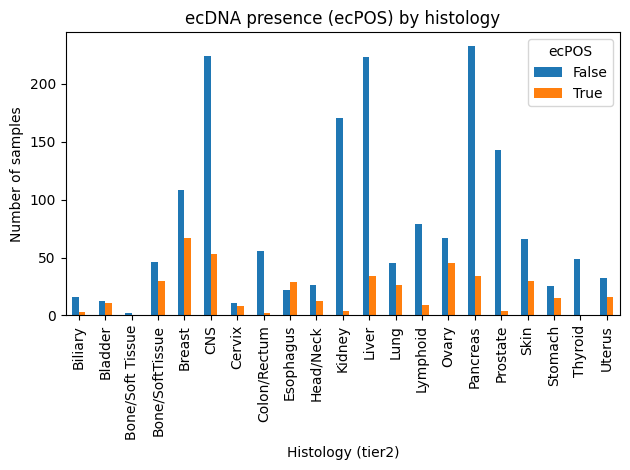

In [74]:

# Assume sample_with_hist exists in the environment

# 1) Create ecPOS column
sample_with_hist['ecPOS'] = sample_with_hist['classification_types'].apply(
    lambda x: 'ecDNA' in x if isinstance(x, list) else False
)

# 2) Prepare data for plotting: count ecPOS per histology
plot_df = (
    sample_with_hist
    .groupby(['histology_tier2', 'ecPOS'])
    .size()
    .unstack(fill_value=0)
)

# 3) Plot (single plot, default matplotlib style/colors)
plot_df.plot(kind='bar')
plt.xlabel('Histology (tier2)')
plt.ylabel('Number of samples')
plt.title('ecDNA presence (ecPOS) by histology')
plt.tight_layout()
plt.show()



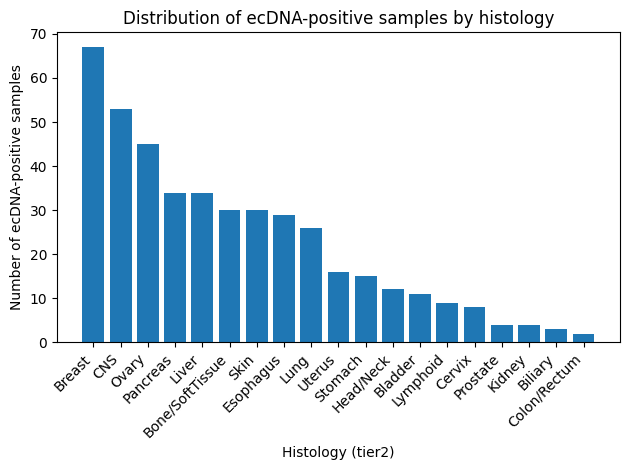

In [75]:
ecpos_only = sample_with_hist[sample_with_hist['ecPOS']]
ecpos_hist_count = (
    ecpos_only
    .groupby('histology_tier2')
    .size()
    .sort_values(ascending=False)
)
ecpos_hist_count


plt.figure()
plt.bar(ecpos_hist_count.index, ecpos_hist_count.values)
plt.xlabel('Histology (tier2)')
plt.ylabel('Number of ecDNA-positive samples')
plt.title('Distribution of ecDNA-positive samples by histology')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


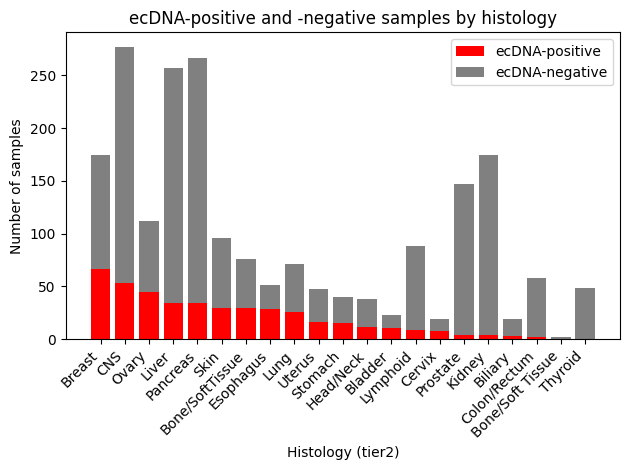

In [76]:
# --- 1. Prepare stacked count table ---
stack_df = (
    sample_with_hist
    .groupby(['histology_tier2', 'ecPOS'])
    .size()
    .unstack(fill_value=0)
)

# Ensure both columns exist
if True not in stack_df.columns:
    stack_df[True] = 0
if False not in stack_df.columns:
    stack_df[False] = 0

# --- 2. Sort by ecDNA-positive (True) count, descending ---
stack_df = stack_df.sort_values(by=True, ascending=False)

# --- 3. Stacked bar plot ---
plt.figure()

plt.bar(
    stack_df.index,
    stack_df[True],
    label='ecDNA-positive',
    color='red'
)

plt.bar(
    stack_df.index,
    stack_df[False],
    bottom=stack_df[True],
    label='ecDNA-negative',
    color='gray'
)

plt.xlabel('Histology (tier2)')
plt.ylabel('Number of samples')
plt.title('ecDNA-positive and -negative samples by histology')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
# gene 문자열 → list
merged_df['oncogene_list'] = (
    merged_df['Oncogenes']
    .str.replace("'", "", regex=False)
    .str.split(r'\s*;\s*')
)
merged_df['oncogene_list']

# gene 문자열 → list
merged_df['allgene_list'] = (
    merged_df['All genes']
    .str.replace("'", "", regex=False)
    .str.split(r'\s*;\s*')
)
merged_df['oncogene_list']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3994    NaN
3995    NaN
3996    NaN
3997    NaN
3998    NaN
Name: oncogene_list, Length: 3999, dtype: object

In [78]:
oncogene_df = (
    merged_df
    .explode('oncogene_list')
    .rename(columns={'oncogene_list': 'gene'})
)
oncogene_df

,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,amplicon_no,classification_type,classification_no,gene,allgene_list
0,73e0b583-b22d-5c8b-ae9a-ad1a54a9b0ce__aa69323a...,DO45081-SP98885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP98885,LINC-JP,HX33T,HX33T,NaN,SA501417,NaN,LINC-JP::HX33,DO45081,HX33,NaN,LIVER,Liver-HCC,ENDODERM,Liver,Hepatocellular carcinoma,Hepatocellular carcinoma,8170/3,"Hepatocellular carcinoma, NOS",NaN,G3,NaN,NaN,NaN,NaN,NaN,Included,WGS,NaN,NaN,NaN,NaN,NaN
1,4835f123-c8c7-5abc-812b-96ed07e294ac__b7299ab6...,DO44872-SP98053,1.0,Complex non-cyclic,NaN,'RUNX2'; 'SUPT3H',956780.0,1.309013,4.964222,4.964222,LowCN,'6:44673885-45443856'; '6:45847715-45903916'; ...,GRCh37,NaN,NaN,SP98053,LIHC-US,TCGA-FV-A23B-01A,TCGA-FV-A23B-01A-11D-A16V-10,d056433d-c3e2-467a-8151-ddf2a6d8683a,SA499894,63adc09c-e1b1-40dd-9c35-2f8276b656fc,LIHC-US::c95ed407-bcc2-44aa-bc59-bf7549f2d665,DO44872,TCGA-FV-A23B,c95ed407-bcc2-44aa-bc59-bf7549f2d665,LIVER,Liver-HCC,ENDODERM,Liver,Hepatocellular carcinoma,Hepatocellular carcinoma,8170/3,"Hepatocellular carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,amplicon1,Complex non-cyclic,1,NaN,"[RUNX2, SUPT3H]"
2,c2119fb0-4428-5b49-937d-1f8f8adb6ffb__86de3ad1...,DO555-SP1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP1132,BLCA-US,TCGA-DK-A3IL-01A,TCGA-DK-A3IL-01A-11D-A20D-08,59d6683f-5eb7-493d-8e8e-78b88be2cd70,SA1556,4838b5a9-968c-4178-bffb-3fafe1f6dc09,BLCA-US::178b28cd-99c3-48dc-8d09-1ef71b4cee80,DO555,TCGA-DK-A3IL,178b28cd-99c3-48dc-8d09-1ef71b4cee80,URINARY BLADDER,Bladder-TCC,ENDODERM,Bladder,Transitional cell carcinoma,Transitional cell carcinoma,8120/3,"Transitional cell carcinoma, NOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,NaN,NaN,NaN,NaN,NaN
3,0c835585-ca5a-566b-bea6-855e71d3ee6e__b977a477...,DO48890-SP107358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP107358,PBCA-DE,ICGC_MB57,ICGC_MB57,NaN,SA517318,NaN,PBCA-DE::ICGC_MB57,DO48890,ICGC_MB57,NaN,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-Medullo,NEURAL_CREST,CNS,Medulloblastoma,Medulloblastoma,9470/3,"Medulloblastoma, NOS",M0,G4,NaN,NaN,NaN,NaN,no treatment,Included,WGS,NaN,NaN,NaN,NaN,NaN
4,3179776c-2dd0-5608-96bc-962b5818d7ae__21e6b48a...,DO48916-SP107408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRCh37,NaN,NaN,SP107408,PBCA-DE,ICGC_MB127,ICGC_MB127,NaN,SA517420,NaN,PBCA-DE::ICGC_MB127,DO48916,ICGC_MB127,NaN,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-Medullo,NEURAL_CREST,CNS,Medulloblastoma,Medulloblastoma,9470/3,"Medulloblastoma, NOS",unknown,G4,NaN,NaN,NaN,NaN,no treatment,GrayList,WGS,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,d3dd745f-3ed4-53e8-b588-8ed81fe45f2e__25d919f3...,DO220823-SP124197,1.0,ecDNA,NaN,'FAM100B'; 'QRICH2'; 'RNF157',150367.0,0.320517,5.721795,5.721795,LowCN,'17:74155827-74306194',GRCh37,NaN,NaN,SP124197,BRCA-EU,CGP_specimen_1403849,PD6043a,NaN,SA557034,NaN,BRCA-EU::CGP_donor_1353428,DO220823,CGP_donor_1353428,NaN,BREAST,Breast-AdenoCA,ECTODERM,Breast,Adenocarcinoma,Infiltrating duct carcinoma,8500/3,"Infiltrating duct carcinoma, NOS",T2N2M0,G3,NaN,1-20%,NaN,NaN,other t

In [79]:
# ecDNA-positive sample 목록
ecpos_samples = set(
    sample_with_hist.loc[sample_with_hist['ecPOS'], 'Sample name']
)

# ecDNA amplicon 위의 oncogene만
oncogene_ecDNA = oncogene_df[
    (oncogene_df['Sample name'].isin(ecpos_samples)) &
    (oncogene_df['classification_type'] == 'ecDNA')
]
# oncogene_ecDNA

In [80]:
oncogene_ecDNA.head()

,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,amplicon_no,classification_type,classification_no,gene,allgene_list
7,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,1.0,ecDNA,'EGFR','EGFR'; 'LANCL2'; 'SEC61G',787009.0,0.272127,176.669436,116.854160,NaN,'7:54706321-55286759'; '7:55289060-55495631',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon1,ecDNA,1,EGFR,"[EGFR, LANCL2, SEC61G]"
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:57792100-58576290'; '17:66321662-66321807',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon2,ecDNA,2,AGAP2,"[AGAP2, ARHGAP9, AVIL, B4GALNT1, CDK4, CTDSP2,..."
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:57792100-58576290'; '17:66321662-66321807',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon2,ecDNA,2,CDK4,"[AGAP2, ARHGAP9, AVIL, B4GALNT1, CDK4, CTDSP2,..."
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:57792100-58576290'; '17:66321662-66321807',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon2,ecDNA,2,DDIT3,"[AGAP2, ARHGAP9, AVIL, B4GALNT1, CDK4, CTDSP2,..."
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:

In [81]:
oncogene_sample = (
    oncogene_ecDNA
    .groupby(['Sample name', 'histology_tier2', 'gene'], as_index=False)
    .agg(
        max_cn=('Feature maximum copy number', 'max')  # 있으면 유지, 없어도 됨
    )
)
oncogene_sample

,Sample name,histology_tier2,gene,max_cn
0,DO1009-SP2152,Breast,HLF,10.297475
1,DO1009-SP2152,Breast,MSI2,10.297475
2,DO1009-SP2152,Breast,RNF43,10.297475
3,DO1009-SP2152,Breast,SRSF1,10.297475
4,DO1010-SP2153,Breast,MYC,8.476819
...,...,...,...,...
1120,DO675-SP1377,Bladder,MLLT3,78.546489
1121,DO675-SP1377,Bladder,WHSC1,78.546489
1122,DO689-SP1419,Bladder,CD274,15.720959
1123,DO689-SP1419,Bladder,MLANA,15.720959


In [82]:

heatmap_count = (
    oncogene_sample
    .groupby(['histology_tier2', 'gene'])
    .size()
    .unstack(fill_value=0)
)
heatmap_count

gene,ABL2,ACTN4,ADAM9,AGAP2,AHI1,AIMP2,AKAP9,AKIRIN2,AKT1,AKT2,ALDH2,ANP32D,AQP1,ARHGEF1,ARHGEF2,ARID2,ASCL1,ATF3,ATM,AXL,BAALC,BAIAP2L1,BCL11A,BCL3,BCL7A,BCL9,BIRC2,BIRC3,BIRC5,BLK,BMP7,BMPR1A,BRD4,BRF2,BRIP1,BTG1,C11orf30,C17orf37,C19orf2,C21orf34,C6orf108,CAV1,CBLC,CBLL1,CBX8,CCDC28A,CCND1,CCND2,CCND3,CCNE1,CD274,CD79A,CDC5L,CDC6,CDH1,CDK12,CDK14,CDK4,CDK6,CDK8,CDKN1A,CDKN1B,CDKN2C,CDX2,CEACAM6,CEBPA,CHCHD7,CHIC2,CKS1B,CLTC,CNTN2,COL1A1,COPS3,COX6C,CRTC1,CSF3,CSF3R,CSNK2A2,CTGF,CTNNB1,CTSZ,CTTN,CUL7,CUX1,CYP24A1,DCD,DCUN1D1,DDHD2,DDIT3,DDX10,DICER1,DIS3,DLX5,DNM2,DUSP12,E2F3,EBF1,ECT2,ECT2L,EEF1D,EGFR,EIF3E,ELK3,EN2,EP300,EPCAM,EPHA2,EPS15,ERBB2,ERBB3,ERCC2,ERCC5,ETV3,FAM189B,FANCE,FANCF,FBXO11,FCGR2B,FDPS,FEZF1,FGF10,FGF3,FGF4,FGF6,FGFR1,FGFR2,FGFR3,FGFR4,FH,FIP1L1,FOXA1,FOXL2,FOXM1,FUS,FYN,GAB2,GAS7,GATA6,GLI1,GLI2,GLO1,GNAI2,GNAS,GPR110,GPR132,GRM1,H3F3B,HAX1,HEY1,HIP1,HLF,HMGA2,HNRNPA1,HOOK3,HOTAIR,HOXC11,HOXC13,HSPA1A,HSPA5,HULC,IDH2,IFNG,IGF1R,IGF2BP1,IL6ST,INPPL1,INTS2,INTS3,INTS4,INTS7,IRS2,ITGA3,JAK1,JAK2,JAZF1,JUN,JUND,JUP,KDM2A,KDM4C,KDM5B,KDR,KIAA1524,KIT,KLF2,KLF5,KLF6,KRAS,LASP1,LCN2,LHFP,LHX1,LIFR,LIN28B,LMO2,LMX1B,LRIG3,LSM1,LYL1,MACC1,MAFB,MALT1,MAP2K1,MBD1,MDM2,MDM4,MECOM,MEIS1,MET,MKL1,MLANA,MLLT3,MLLT6,MMP12,MOS,MPL,MRAS,MSH2,MSH6,MSI2,MUC1,MYB,MYC,MYCL1,MYCN,MYD88,MYST3,MYST4,NACA,NCOA2,NDRG1,NEDD9,NF2,NFE2L2,NME1,NOTCH1,NOTCH4,NRAS,NSD1,NTRK1,NUAK2,NUMA1,PA2G4,PAK1,PAK7,PBX1,PBX2,PCM1,PDGFRA,PDZK1IP1,PER1,PHOX2B,PIK3CA,PIM1,PLAC2,PLAG1,PMS2,POU5F1,PPARG,PPM1D,PPP1R10,PPP1R13L,PPP1R14A,PRCC,PRDM1,PRDM14,PRDM9,PRKCI,PTK7,PTP4A1,PTP4A2,PTPN11,PVT1,RAB11A,RAB22A,RAB23,RAB8A,RAC1,RAF1,RARA,RASSF1,RBM14,REL,RET,RGL4,RGR,RIT1,RNF43,RPL23,RRAS2,RSF1,S100A4,S100A7,S100A8,SALL4,SART3,SDC4,SDHC,SEC62,SERTAD1,SERTAD3,SFPQ,SGK1,SH2B3,SKI,SKIL,SLC12A5,SLC34A2,SLC3A2,SMARCA4,SMARCE1,SMO,SMURF1,SNORA42,SOX2,SOX4,SPAG9,SPARC,SQSTM1,SRC,SREBF1,SRSF1,SRSF3,SS18,SUZ12,SYT1,TAC1,TACSTD2,TBC1D15,TBC1D7,TBX2,TBX3,TCEA1,TCL1A,TCL1B,TCL6,TERT,TFEB,TFG,THRA,THRAP3,TLE1,TNS4,TPD52,TPM3,TPM4,TPR,TRAF6,TRIB1,TRIM33,TRIO,TRIP6,TRRAP,TXN,TYMS,UBE2C,UBE3C,UBR5,UCA1,UCHL1,USP22,VAV1,VAV3,WAPAL,WHSC1,WHSC1L1,WIF1,WISP1,WNT2,XCL1,YAP1,YBX1,YEATS4,YES1,YWHAG,YWHAZ,YY1,YY1AP1,ZIC2,ZNF217,ZNF521,ZNF703
histology_tier2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Biliary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bladder,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [83]:
ecpos_count_by_hist = (
    sample_with_hist[sample_with_hist['ecPOS']]
    .groupby('histology_tier2')
    .size()
)

heatmap_ratio = heatmap_count.div(ecpos_count_by_hist, axis=0)
heatmap_ratio

gene,ABL2,ACTN4,ADAM9,AGAP2,AHI1,AIMP2,AKAP9,AKIRIN2,AKT1,AKT2,ALDH2,ANP32D,AQP1,ARHGEF1,ARHGEF2,ARID2,ASCL1,ATF3,ATM,AXL,BAALC,BAIAP2L1,BCL11A,BCL3,BCL7A,BCL9,BIRC2,BIRC3,BIRC5,BLK,BMP7,BMPR1A,BRD4,BRF2,BRIP1,BTG1,C11orf30,C17orf37,C19orf2,C21orf34,C6orf108,CAV1,CBLC,CBLL1,CBX8,CCDC28A,CCND1,CCND2,CCND3,CCNE1,CD274,CD79A,CDC5L,CDC6,CDH1,CDK12,CDK14,CDK4,CDK6,CDK8,CDKN1A,CDKN1B,CDKN2C,CDX2,CEACAM6,CEBPA,CHCHD7,CHIC2,CKS1B,CLTC,CNTN2,COL1A1,COPS3,COX6C,CRTC1,CSF3,CSF3R,CSNK2A2,CTGF,CTNNB1,CTSZ,CTTN,CUL7,CUX1,CYP24A1,DCD,DCUN1D1,DDHD2,DDIT3,DDX10,DICER1,DIS3,DLX5,DNM2,DUSP12,E2F3,EBF1,ECT2,ECT2L,EEF1D,EGFR,EIF3E,ELK3,EN2,EP300,EPCAM,EPHA2,EPS15,ERBB2,ERBB3,ERCC2,ERCC5,ETV3,FAM189B,FANCE,FANCF,FBXO11,FCGR2B,FDPS,FEZF1,FGF10,FGF3,FGF4,FGF6,FGFR1,FGFR2,FGFR3,FGFR4,FH,FIP1L1,FOXA1,FOXL2,FOXM1,FUS,FYN,GAB2,GAS7,GATA6,GLI1,GLI2,GLO1,GNAI2,GNAS,GPR110,GPR132,GRM1,H3F3B,HAX1,HEY1,HIP1,HLF,HMGA2,HNRNPA1,HOOK3,HOTAIR,HOXC11,HOXC13,HSPA1A,HSPA5,HULC,IDH2,IFNG,IGF1R,IGF2BP1,IL6ST,INPPL1,INTS2,INTS3,INTS4,INTS7,IRS2,ITGA3,JAK1,JAK2,JAZF1,JUN,JUND,JUP,KDM2A,KDM4C,KDM5B,KDR,KIAA1524,KIT,KLF2,KLF5,KLF6,KRAS,LASP1,LCN2,LHFP,LHX1,LIFR,LIN28B,LMO2,LMX1B,LRIG3,LSM1,LYL1,MACC1,MAFB,MALT1,MAP2K1,MBD1,MDM2,MDM4,MECOM,MEIS1,MET,MKL1,MLANA,MLLT3,MLLT6,MMP12,MOS,MPL,MRAS,MSH2,MSH6,MSI2,MUC1,MYB,MYC,MYCL1,MYCN,MYD88,MYST3,MYST4,NACA,NCOA2,NDRG1,NEDD9,NF2,NFE2L2,NME1,NOTCH1,NOTCH4,NRAS,NSD1,NTRK1,NUAK2,NUMA1,PA2G4,PAK1,PAK7,PBX1,PBX2,PCM1,PDGFRA,PDZK1IP1,PER1,PHOX2B,PIK3CA,PIM1,PLAC2,PLAG1,PMS2,POU5F1,PPARG,PPM1D,PPP1R10,PPP1R13L,PPP1R14A,PRCC,PRDM1,PRDM14,PRDM9,PRKCI,PTK7,PTP4A1,PTP4A2,PTPN11,PVT1,RAB11A,RAB22A,RAB23,RAB8A,RAC1,RAF1,RARA,RASSF1,RBM14,REL,RET,RGL4,RGR,RIT1,RNF43,RPL23,RRAS2,RSF1,S100A4,S100A7,S100A8,SALL4,SART3,SDC4,SDHC,SEC62,SERTAD1,SERTAD3,SFPQ,SGK1,SH2B3,SKI,SKIL,SLC12A5,SLC34A2,SLC3A2,SMARCA4,SMARCE1,SMO,SMURF1,SNORA42,SOX2,SOX4,SPAG9,SPARC,SQSTM1,SRC,SREBF1,SRSF1,SRSF3,SS18,SUZ12,SYT1,TAC1,TACSTD2,TBC1D15,TBC1D7,TBX2,TBX3,TCEA1,TCL1A,TCL1B,TCL6,TERT,TFEB,TFG,THRA,THRAP3,TLE1,TNS4,TPD52,TPM3,TPM4,TPR,TRAF6,TRIB1,TRIM33,TRIO,TRIP6,TRRAP,TXN,TYMS,UBE2C,UBE3C,UBR5,UCA1,UCHL1,USP22,VAV1,VAV3,WAPAL,WHSC1,WHSC1L1,WIF1,WISP1,WNT2,XCL1,YAP1,YBX1,YEATS4,YES1,YWHAG,YWHAZ,YY1,YY1AP1,ZIC2,ZNF217,ZNF521,ZNF703
histology_tier2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Biliary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

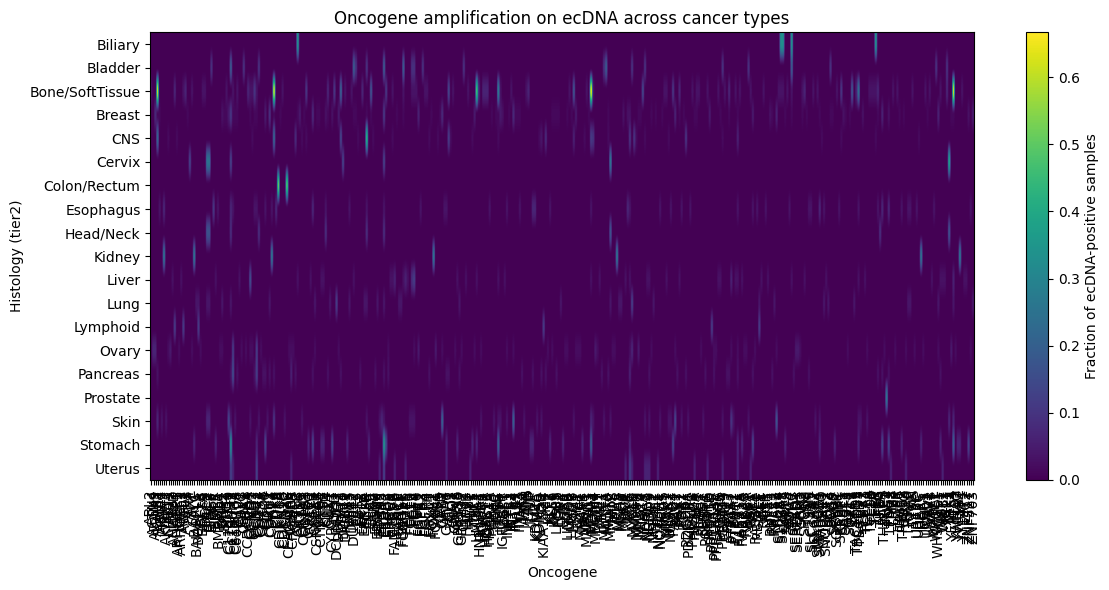

In [84]:
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_ratio, aspect='auto')

plt.colorbar(label='Fraction of ecDNA-positive samples')

plt.xticks(
    ticks=np.arange(len(heatmap_ratio.columns)),
    labels=heatmap_ratio.columns,
    rotation=90
)
plt.yticks(
    ticks=np.arange(len(heatmap_ratio.index)),
    labels=heatmap_ratio.index
)

plt.xlabel('Oncogene')
plt.ylabel('Histology (tier2)')
plt.title('Oncogene amplification on ecDNA across cancer types')
plt.tight_layout()
plt.show()

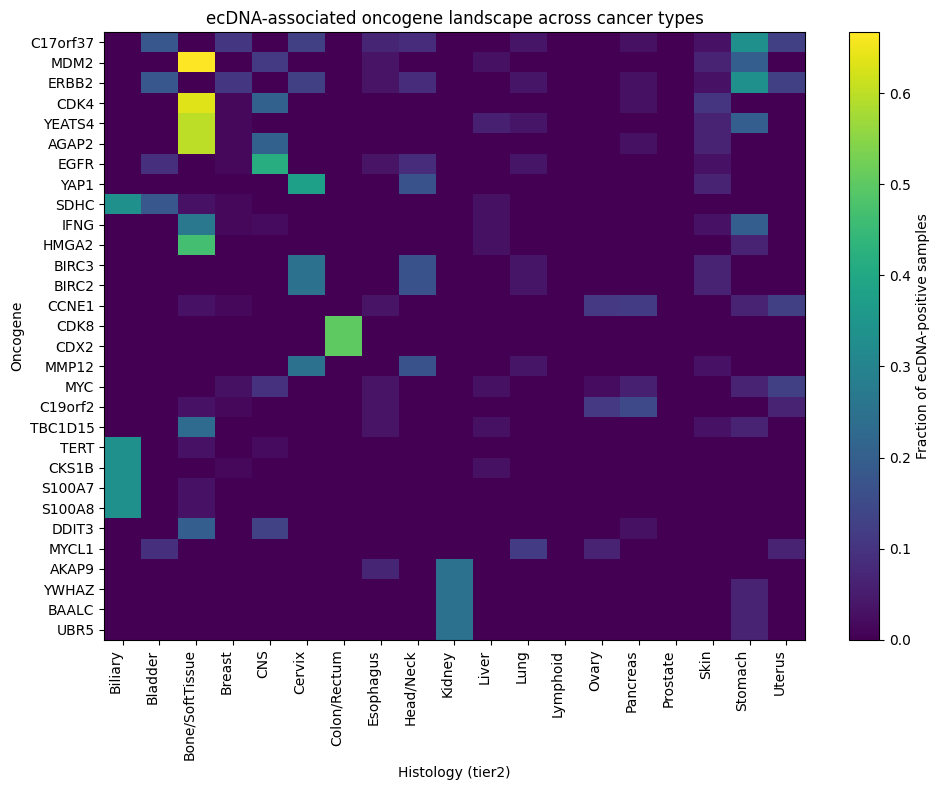

In [85]:
# gene별 평균 ecDNA 빈도
gene_order = (
    heatmap_ratio
    .mean(axis=0)
    .sort_values(ascending=False)
    .index
)

# transpose + gene 정렬
heatmap_plot = heatmap_ratio.T.loc[gene_order]

##===== subset the count of genes
topN = 30
heatmap_plot_top = heatmap_plot.head(topN)
##===== Plot
plt.figure(figsize=(10, 8))

plt.imshow(heatmap_plot_top, aspect='auto')

plt.colorbar(label='Fraction of ecDNA-positive samples')

plt.xticks(
    ticks=np.arange(len(heatmap_plot_top.columns)),
    labels=heatmap_plot_top.columns,
    rotation=90,
    ha='right'
)

plt.yticks(
    ticks=np.arange(len(heatmap_plot_top.index)),
    labels=heatmap_plot_top.index
)

plt.xlabel('Histology (tier2)')
plt.ylabel('Oncogene')
plt.title('ecDNA-associated oncogene landscape across cancer types')

plt.tight_layout()
plt.show()

In [86]:
pan_gene_stats = (
    heatmap_ratio
    .T
    .assign(
        n_histologies=lambda df: (df > 0).sum(axis=1),
        mean_ratio=lambda df: df.mean(axis=1),
        max_ratio=lambda df: df.max(axis=1)
    )
    .sort_values(
        ['n_histologies', 'mean_ratio'],
        ascending=False
    )
)
pan_gene_stats

histology_tier2,Biliary,Bladder,Bone/SoftTissue,Breast,CNS,Cervix,Colon/Rectum,Esophagus,Head/Neck,Kidney,Liver,Lung,Lymphoid,Ovary,Pancreas,Prostate,Skin,Stomach,Uterus,n_histologies,mean_ratio,max_ratio
gene,,,,,,,,,,,,,,,,,,,,,,
C17orf37,0.0,0.181818,0.0,0.104478,0.000000,0.125,0.0,0.068966,0.083333,0.0,0.000000,0.038462,0.0,0.000000,0.029412,0.0,0.033333,0.333333,0.1250,10,0.556157,10.0
ERBB2,0.0,0.181818,0.0,0.104478,0.000000,0.125,0.0,0.034483,0.083333,0.0,0.000000,0.038462,0.0,0.000000,0.029412,0.0,0.033333,0.333333,0.1250,10,0.554433,10.0
MYC,0.0,0.000000,0.0,0.029851,0.094340,0.000,0.0,0.034483,0.000000,0.0,0.029412,0.000000,0.0,0.022222,0.058824,0.0,0.000000,0.066667,0.1250,8,0.423040,8.0
PVT1,0.0,0.000000,0.0,0.014925,0.056604,0.000,0.0,0.034483,0.000000,0.0,0.029412,0.000000,0.0,0.022222,0.029412,0.0,0.000000,0.066667,0.0625,8,0.415811,8.0
EGFR,0.0,0.090909,0.0,0.014925,0.415094,0.000,0.0,0.034483,0.083333,0.0,0.000000,0.038462,0.0,0.000000,0.000000,0.0,0.033333,0.000000,0.0000,7,0.385527,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRSF3,0.0,0.000000,0.0,0.014925,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,1,0.050746,1.0
SUZ12,0.0,0.000000,0.0,0.014925,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,1,0.050746,1.0
TRAF6,0.0,0.000000,0.0,0.014925,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,1,0.050746,1.0


In [87]:
pan_oncogenes = pan_gene_stats[
    (pan_gene_stats['n_histologies'] >= 5) &
    (pan_gene_stats['mean_ratio'] >= 0.1)
].index
pan_oncogenes

Index(['C17orf37', 'ERBB2', 'MYC', 'PVT1', 'EGFR', 'CCNE1', 'MDM2', 'YEATS4',
       'IFNG', 'C19orf2', 'CDK4', 'AGAP2', 'SDHC', 'TBC1D15', 'FGF4', 'CCND1'],
      dtype='object', name='gene')

In [88]:
civic_Pan_cancer=pd.read_csv('../data/civic_Pan_cancer.csv')
print(civic_Pan_cancer.shape)
civic_Pan_cancer.head()

(4765, 25)


,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,significance,evidence_statement,citation_id,source_type,asco_abstract_id,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
0,JAK2 V617F,64,Lymphoid Leukemia,1037.0,NaN,NaN,NaN,Diagnostic,Supports,B,Negative,JAK2 V617F is not associated with lymphoid leu...,16081687,PubMed,NaN,"Levine et al., 2005",NaN,4.0,accepted,1,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/1,https://civicdb.org/links/molecular_profiles/64,False
1,PDGFRA D842V,99,Gastrointestinal Stromal Tumor,9253.0,NaN,NaN,NaN,Diagnostic,Supports,B,Negative,GIST tumors harboring PDGFRA D842V mutation ar...,15146165,PubMed,NaN,"Lasota et al., 2004",NaN,3.0,accepted,2,Somatic,2023-01-09 21:46:27 UTC,https://civicdb.org/links/evidence_items/2,https://civicdb.org/links/molecular_profiles/99,False
2,DNMT3A R882,32,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,Young AML patients (<60 years old) with DNMT3A...,22490330,PubMed,NaN,"Ribeiro et al., 2012",NaN,3.0,accepted,4,Somatic,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/4,https://civicdb.org/links/molecular_profiles/32,False
3,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,JAK2 V617F is associated with myeloid malignan...,16081687,PubMed,NaN,"Levine et al., 2005",NaN,4.0,accepted,5,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/5,https://civicdb.org/links/molecular_profiles/64,False
4,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,JAK2 V617F is associated with myeloid neoplasm...,16081687,PubMed,NaN,"Levine et al., 2005",NaN,4.0,accepted,6,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/6,https://civicdb.org/links/molecular_profiles/64,False


In [89]:
civic_Pan_cancer_ERBB2 = civic_Pan_cancer[
    (civic_Pan_cancer['molecular_profile'].str.contains('ERBB2 Amp', na=False))&
    (civic_Pan_cancer['molecular_profile'].str.contains('ERBB2 Amp', na=False))
]
civic_Pan_cancer_ERBB2

,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,significance,evidence_statement,citation_id,source_type,asco_abstract_id,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
461,ERBB2 Amplification,302,Her2-receptor Positive Breast Cancer,60079.0,NaN,Trastuzumab,NaN,Predictive,Supports,B,Sensitivity/Response,A randomized clinical trial of 469 patients wi...,11248153,PubMed,NaN,"Slamon et al., 2001",NaN,5.0,accepted,528,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/528,https://civicdb.org/links/molecular_profiles/302,False
462,ERBB2 Amplification,302,Her2-receptor Positive Breast Cancer,60079.0,NaN,Trastuzumab,NaN,Predictive,Supports,B,Sensitivity/Response,A randomized clinical trial of 186 patients wi...,15911866,PubMed,NaN,"Marty et al., 2005",NaN,5.0,accepted,529,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/529,https://civicdb.org/links/molecular_profiles/302,False
598,ERBB2 Amplification,302,Breast Cancer,1612.0,NaN,AKTi-1/2,NaN,Predictive,Supports,D,Sensitivity/Response,Xenografts established from breast cancer cell...,18725974,PubMed,NaN,"She et al., 2008",NaN,3.0,accepted,760,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/760,https://civicdb.org/links/molecular_profiles/302,False
599,ERBB2 Amplification,302,Her2-receptor Positive Breast Cancer,60079.0,NaN,Neratinib,NaN,Predictive,Supports,B,Sensitivity/Response,Oral neratinib showed objective response rates...,20142587,PubMed,NaN,"Burstein et al., 2010",NaN,3.0,accepted,761,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/761,https://civicdb.org/links/molecular_profiles/302,False
716,ERBB2 Amplification,302,Uterine Corpus Endometrial Carcinoma,50939.0,NaN,Afatinib,NaN,Predictive,Supports,D,Sensitivity/Response,Eight uterine cancer cell lines (four with ERB...,25268372,PubMed,NaN,"Schwab et al., 2014",NaN,2.0,accepted,886,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/886,https://civicdb.org/links/molecular_profiles/302,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,ERBB2 Amplification,302,Stomach Cancer,10534.0,NaN,Trastuzumab Deruxtecan,NaN,Predictive,Supports,B,Sensitivity/Response,"In a phase 1 trial, 44 patients with HER2-posi...",31047804,PubMed,NaN,"Shitara et al., 2019",NCT02564900,3.0,accepted,7647,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/7647,https://civicdb.org/links/molecular_profiles/302,False
3650,ERBB2 Amplification,302,Colorectal Cancer,9256.0,NaN,Afatinib,NaN,Predictive,Supports,D,Sensitivity/Response,Afatinib monotherapy was tested in patient-der...,26296355,PubMed,NaN,"Leto et al., 2015",NaN,3.0,accepted,7807,Somatic,2023-01-09 21:46:32 UTC,https://civicdb.org/links/evidence_items/7807,https://civicdb.org/links/molecular_profiles/302,False
4029,ERBB2 Amplification,302,Childhood Ependymoma,5509.0,NaN,Lapatinib,NaN,Predictive,Supports,B,Sensitivity/Response,"From a phase one clinical trial, pediatric pat...",20713864,PubMed,NaN,"Fouladi et al., 2010",NaN,1.0,accepted,9778,NaN,2023-02-03 15:55:46 UTC,https://civicdb.org/links/evidence_items/9778,https://civicdb.org/links/molecular_profiles/302,False
4302,ERBB2 Amplification,302,Breast Cancer,1612.0,NaN,Margetuximab,NaN,Predictive,Supports,A,Sensitivity/Response,"In this phase III, randomized, open-label tria...",33480963,PubMed,NaN,"Rugo et al., 2021",NCT02492711,5.0,accepted,11249,Somatic,2024-02-14 20:51:42 UTC,https://civicdb.org/links/evidence_items/11249,https://civicdb.org/links/molecular_profiles/302,False


In [150]:
civic_Pan_cancer['disease'].unique().tolist()

['Lymphoid Leukemia',
 'Gastrointestinal Stromal Tumor',
 'Acute Myeloid Leukemia',
 'Chronic Myeloid Leukemia',
 'Bone Marrow Cancer',
 'Acute Leukemia',
 'Melanoma',
 'Lung Non-small Cell Carcinoma',
 'Polycythemia Vera',
 'Colorectal Cancer',
 'Inflammatory Myofibroblastic Tumor',
 'Neuroblastoma',
 'Cancer',
 'Medullary Thyroid Carcinoma',
 'Thyroid Cancer',
 'Papillary Thyroid Carcinoma',
 'Lung Adenocarcinoma',
 'Acute Myeloid Leukemia With Mutated NPM1',
 'Bladder Carcinoma',
 'Glioblastoma',
 'Ovarian Cancer',
 'Stomach Cancer',
 'Breast Cancer',
 'Lung Cancer',
 'T-cell Lymphoblastic Leukemia/lymphoma',
 'Estrogen-receptor Positive Breast Cancer',
 'Cholangiocarcinoma',
 'Malignant Anus Melanoma',
 'Acute Promyelocytic Leukemia',
 'Invasive Bladder Transitional Cell Carcinoma',
 'Myelodysplastic Syndrome',
 'Malignant Astrocytoma',
 'Head And Neck Squamous Cell Carcinoma',
 'Mantle Cell Lymphoma',
 'Gastric Adenosquamous Carcinoma',
 'Multiple Myeloma',
 'Acute Lymphoblastic L

In [153]:
oncogene_ecDNA.columns

Index(['Feature ID', 'Sample name', 'AA amplicon number', 'Classification',
       'Oncogenes', 'All genes', 'Captured interval length',
       'Complexity score', 'Feature maximum copy number',
       'Feature median copy number', 'Filter flag', 'Location',
       'Reference version', 'Sample type', 'Tissue of origin',
       '# icgc_specimen_id', 'project_code', 'submitted_specimen_id',
       'submitted_sample_id', 'tcga_specimen_uuid', 'icgc_sample_id',
       'tcga_sample_uuid', 'donor_unique_id', 'icgc_donor_id',
       'submitted_donor_id', 'tcga_donor_uuid', 'organ_system',
       'histology_abbreviation', 'histology_tier1', 'histology_tier2',
       'histology_tier3', 'histology_tier4', 'tumour_histological_code',
       'tumour_histological_type', 'tumour_stage', 'tumour_grade',
       'percentage_cellularity', 'level_of_cellularity',
       'tcga_expert_re-review', 'tumour_histological_comment',
       'specimen_donor_treatment_type', 'donor_wgs_included_excluded',
       's

In [154]:
oncogene_ecDNA[oncogene_ecDNA['classification_type']=='ecDNA'].head()
oncogene_ecDNA_sampleid = oncogene_ecDNA[oncogene_ecDNA['classification_type']=='ecDNA']['Sample name'].unique().tolist()

sample_test = oncogene_ecDNA_sampleid[4]
oncogene_ecDNA[oncogene_ecDNA['Sample name']==sample_test][['Sample name','classification_type','Oncogenes','gene','Feature maximum copy number','histology_abbreviation']]

,Sample name,classification_type,Oncogenes,gene,Feature maximum copy number,histology_abbreviation
27,DO43378-SP94661,ecDNA,NaN,NaN,4.660140,Uterus-AdenoCA
29,DO43378-SP94661,ecDNA,NaN,NaN,4.678463,Uterus-AdenoCA
32,DO43378-SP94661,ecDNA,'C17orf37'; 'ERBB2',C17orf37,125.640726,Uterus-AdenoCA
32,DO43378-SP94661,ecDNA,'C17orf37'; 'ERBB2',ERBB2,125.640726,Uterus-AdenoCA


In [156]:

import re

def civic_filter_gene_amplification(civic_df, gene):
    """
    CIViC에서
    - 특정 gene
    - Amplification 계열 molecular_profile
    """
    amp_pattern = re.compile(
        rf'\b{gene}\b.*(Amplification|Overexpression|Gain)',
        re.IGNORECASE
    )

    return civic_df[
        civic_df['molecular_profile'].str.contains(amp_pattern, na=False)
    ].copy()

gene_name='ERBB2'
civic_filter_gene_amplification(civic_Pan_cancer, gene_name)
    

/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/3524511852.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  civic_df['molecular_profile'].str.contains(amp_pattern, na=False)


,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,significance,evidence_statement,citation_id,source_type,asco_abstract_id,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
461,ERBB2 Amplification,302,Her2-receptor Positive Breast Cancer,60079.0,NaN,Trastuzumab,NaN,Predictive,Supports,B,Sensitivity/Response,A randomized clinical trial of 469 patients wi...,11248153,PubMed,NaN,"Slamon et al., 2001",NaN,5.0,accepted,528,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/528,https://civicdb.org/links/molecular_profiles/302,False
462,ERBB2 Amplification,302,Her2-receptor Positive Breast Cancer,60079.0,NaN,Trastuzumab,NaN,Predictive,Supports,B,Sensitivity/Response,A randomized clinical trial of 186 patients wi...,15911866,PubMed,NaN,"Marty et al., 2005",NaN,5.0,accepted,529,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/529,https://civicdb.org/links/molecular_profiles/302,False
598,ERBB2 Amplification,302,Breast Cancer,1612.0,NaN,AKTi-1/2,NaN,Predictive,Supports,D,Sensitivity/Response,Xenografts established from breast cancer cell...,18725974,PubMed,NaN,"She et al., 2008",NaN,3.0,accepted,760,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/760,https://civicdb.org/links/molecular_profiles/302,False
599,ERBB2 Amplification,302,Her2-receptor Positive Breast Cancer,60079.0,NaN,Neratinib,NaN,Predictive,Supports,B,Sensitivity/Response,Oral neratinib showed objective response rates...,20142587,PubMed,NaN,"Burstein et al., 2010",NaN,3.0,accepted,761,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/761,https://civicdb.org/links/molecular_profiles/302,False
716,ERBB2 Amplification,302,Uterine Corpus Endometrial Carcinoma,50939.0,NaN,Afatinib,NaN,Predictive,Supports,D,Sensitivity/Response,Eight uterine cancer cell lines (four with ERB...,25268372,PubMed,NaN,"Schwab et al., 2014",NaN,2.0,accepted,886,Somatic,2023-01-09 21:46:31 UTC,https://civicdb.org/links/evidence_items/886,https://civicdb.org/links/molecular_profiles/302,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3650,ERBB2 Amplification,302,Colorectal Cancer,9256.0,NaN,Afatinib,NaN,Predictive,Supports,D,Sensitivity/Response,Afatinib monotherapy was tested in patient-der...,26296355,PubMed,NaN,"Leto et al., 2015",NaN,3.0,accepted,7807,Somatic,2023-01-09 21:46:32 UTC,https://civicdb.org/links/evidence_items/7807,https://civicdb.org/links/molecular_profiles/302,False
4029,ERBB2 Amplification,302,Childhood Ependymoma,5509.0,NaN,Lapatinib,NaN,Predictive,Supports,B,Sensitivity/Response,"From a phase one clinical trial, pediatric pat...",20713864,PubMed,NaN,"Fouladi et al., 2010",NaN,1.0,accepted,9778,NaN,2023-02-03 15:55:46 UTC,https://civicdb.org/links/evidence_items/9778,https://civicdb.org/links/molecular_profiles/302,False
4302,ERBB2 Amplification,302,Breast Cancer,1612.0,NaN,Margetuximab,NaN,Predictive,Supports,A,Sensitivity/Response,"In this phase III, randomized, open-label tria...",33480963,PubMed,NaN,"Rugo et al., 2021",NCT02492711,5.0,accepted,11249,Somatic,2024-02-14 20:51:42 UTC,https://civicdb.org/links/evidence_items/11249,https://civicdb.org/links/molecular_profiles/302,False
4402,ERBB2 Amplification,302,Colorectal Cancer,9256.0,NaN,"Trastuzumab,Pertuzumab",Combination,Predictive,Supports,B,Sensitivity/Response,In this clinical study of 38 patients with col...,36315917,PubMed,NaN,"Gupta et al., 2022",NCT02693535,3.0,accepted,11668,Somatic,2024-02-01 17:28:15 UTC,https://civicdb.org/links/evidence_items/11668,https://civicdb.org/links/molecular_profiles/302,False


In [157]:
def parse_histology_abbrev(h):
    if pd.isna(h):
        return None, []

    h = h.lower()
    parts = h.split('-')
    organ = parts[0]

    subtype_keywords = []
    if 'adeno' in h:
        subtype_keywords.append('adeno')
    if 'scc' in h:
        subtype_keywords.append('squamous')
    if 'gbm' in h:
        subtype_keywords.append('glioblastoma')
    if 'melanoma' in h:
        subtype_keywords.append('melanoma')
    if 'rcc' in h:
        subtype_keywords.append('renal')

    return organ, subtype_keywords


def civic_match_by_histology(civic_df, hist_abbrev):
    organ, subtype_keywords = parse_histology_abbrev(hist_abbrev)

    if organ is None:
        return civic_df.iloc[0:0]

    def score(disease):
        if pd.isna(disease):
            return 0
        d = disease.lower()
        s = 0
        if organ in d:
            s += 2
        for k in subtype_keywords:
            if k in d:
                s += 2
        if any(x in d for x in ['syndrome', 'disease']):
            s -= 2
        return s

    civic_df = civic_df.copy()
    civic_df['disease_score'] = civic_df['disease'].apply(score)

    return civic_df[civic_df['disease_score'] > 0] \
        .sort_values('disease_score', ascending=False)
        
def get_sample_ecDNA_civic_therapies(
    sample_name,
    oncogene_ecDNA,
    civic_Pan_cancer
):
    # 1. sample의 ecDNA oncogene + histology
    sample_df = oncogene_ecDNA[
        (oncogene_ecDNA['Sample name'] == sample_name) &
        (oncogene_ecDNA['classification_type'] == 'ecDNA')
    ][['gene', 'Feature maximum copy number', 'histology_abbreviation']] \
        .dropna(subset=['gene'])

    if sample_df.empty:
        return pd.DataFrame({
            'Sample name': [sample_name],
            'note': ['No ecDNA oncogene']
        })

    hist_abbrev = sample_df['histology_abbreviation'].iloc[0]
    genes = sample_df['gene'].unique().tolist()

    results = []

    # 2. gene 하나씩 CIViC lookup
    for gene in genes:
        civic_gene_amp = civic_filter_gene_amplification(
            civic_Pan_cancer, gene
        )

        if civic_gene_amp.empty:
            results.append({
                'Sample name': sample_name,
                'gene': gene,
                'note': 'No CIViC amplification evidence'
            })
            continue

        # 3. disease 매칭
        civic_matched = civic_match_by_histology(
            civic_gene_amp, hist_abbrev
        )

        if civic_matched.empty:
            civic_gene_amp = civic_gene_amp.copy()
            civic_gene_amp['Sample name'] = sample_name
            civic_gene_amp['gene'] = gene
            civic_gene_amp['note'] = 'Gene-level only (disease relaxed)'
            results.append(
                civic_gene_amp[
                    [
                        'Sample name',
                        'gene',
                        'molecular_profile',
                        'disease',
                        'therapies',
                        'evidence_level',
                        'significance',
                        'note'
                    ]
                ]
            )
        else:
            civic_matched = civic_matched.copy()
            civic_matched['Sample name'] = sample_name
            civic_matched['gene'] = gene
            civic_matched['note'] = 'Histology matched'
            results.append(
                civic_matched[
                    [
                        'Sample name',
                        'gene',
                        'molecular_profile',
                        'disease',
                        'therapies',
                        'evidence_level',
                        'significance',
                        'disease_score',
                        'note'
                    ]
                ]
            )

    return pd.concat(
        [r for r in results if isinstance(r, pd.DataFrame)],
        ignore_index=True
    )

In [162]:
sample_test = oncogene_ecDNA_sampleid[5]

get_sample_ecDNA_civic_therapies(
    sample_test,
    oncogene_ecDNA,
    civic_Pan_cancer
)

/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/3524511852.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  civic_df['molecular_profile'].str.contains(amp_pattern, na=False)
/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/3524511852.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  civic_df['molecular_profile'].str.contains(amp_pattern, na=False)
/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/3524511852.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  civic_df['molecular_profile'].str.contains(amp_pattern, na=False)


,Sample name,gene,molecular_profile,disease,therapies,evidence_level,significance,note
0,DO219966-SP121831,CCNE1,CCNE1 Overexpression,Breast Cancer,NaN,B,Poor Outcome,Gene-level only (disease relaxed)
1,DO219966-SP121831,CCNE1,CCNE1 Overexpression,Gastric Adenosquamous Carcinoma,NaN,B,Poor Outcome,Gene-level only (disease relaxed)
2,DO219966-SP121831,CCNE1,CCNE1 Amplification,Ovarian Carcinoma,NaN,B,Poor Outcome,Gene-level only (disease relaxed)
3,DO219966-SP121831,CCNE1,CCNE1 Amplification,Estrogen-receptor Positive Breast Cancer,Palbociclib,D,Resistance,Gene-level only (disease relaxed)
4,DO219966-SP121831,CCNE1,CCNE1 Overexpression,Ovarian Cancer,CDK Inhibitor SNS-032,D,Sensitivity/Response,Gene-level only (disease relaxed)
5,DO219966-SP121831,CCNE1,CCNE1 Amplification,Ovarian Serous Cystadenocarcinoma,"Akt Inhibitor MK2206,Dinaciclib",D,Sensitivity/Response,Gene-level only (disease relaxed)
6,DO219966-SP121831,CCNE1,CCNE1 Amplification,Ovarian Carcinoma,"Lunresertib,Camonsertib",D,Sensitivity/Response,Gene-level only (disease relaxed)
7,DO219966-SP121831,CCNE1,CCNE1 Amplification,Endometrial Carcinoma,"Lunresertib,Camonsertib",D,Sensitivity/Response,Gene-level only (disease relaxed)
8,DO219966-SP121831,CDK4,CDK4 Amplification,Liposarcoma,Palbociclib,B,Sensitivity/Response,Gene-level only (disease relaxed)
9,DO219966-SP121831,CDK4,CDK4 Amplification,Liposarcoma,Palbociclib,B,Sensitivity/Response,Gene-level only (disease relaxed)


In [163]:
oncogene_ecDNA[oncogene_ecDNA['Sample name']==sample_test]

,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,amplicon_no,classification_type,classification_no,gene,allgene_list
35,4fa6b2f6-332b-5969-8f8a-c738e643a9e5__f02035c9...,DO219966-SP121831,1.0,ecDNA,'AGAP2'; 'C19orf2'; 'CCNE1'; 'CDK4'; 'ELK3'; '...,'ACSS3'; 'AGAP2'; 'ALX1'; 'APOF'; 'AVIL'; 'BBS...,14759501.0,2.762679,174.719549,32.495733,NaN,'19:28539243-28556341'; '19:28791237-29748777'...,GRCh37,NaN,NaN,SP121831,SARC-US,TCGA-DX-A3LT-01A,TCGA-DX-A3LT-01A-12D-A21Q-09,32f8354a-7d2f-467b-afed-e7f91369615f,SA554650,a2f02ff7-8433-4cb5-9324-34f13edeaca1,SARC-US::e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,DO219966,TCGA-DX-A3LT,e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,BONE & SOFT TISSUE,SoftTissue-Liposarc,MESODERM,Bone/SoftTissue,"Liposarcoma, soft tissue",Liposarcoma,8858/3,Liposarcoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,amplicon1,ecDNA,2,AGAP2,"[ACSS3, AGAP2, ALX1, APOF, AVIL, BBS10, BEST3,..."
35,4fa6b2f6-332b-5969-8f8a-c738e643a9e5__f02035c9...,DO219966-SP121831,1.0,ecDNA,'AGAP2'; 'C19orf2'; 'CCNE1'; 'CDK4'; 'ELK3'; '...,'ACSS3'; 'AGAP2'; 'ALX1'; 'APOF'; 'AVIL'; 'BBS...,14759501.0,2.762679,174.719549,32.495733,NaN,'19:28539243-28556341'; '19:28791237-29748777'...,GRCh37,NaN,NaN,SP121831,SARC-US,TCGA-DX-A3LT-01A,TCGA-DX-A3LT-01A-12D-A21Q-09,32f8354a-7d2f-467b-afed-e7f91369615f,SA554650,a2f02ff7-8433-4cb5-9324-34f13edeaca1,SARC-US::e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,DO219966,TCGA-DX-A3LT,e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,BONE & SOFT TISSUE,SoftTissue-Liposarc,MESODERM,Bone/SoftTissue,"Liposarcoma, soft tissue",Liposarcoma,8858/3,Liposarcoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,amplicon1,ecDNA,2,C19orf2,"[ACSS3, AGAP2, ALX1, APOF, AVIL, BBS10, BEST3,..."
35,4fa6b2f6-332b-5969-8f8a-c738e643a9e5__f02035c9...,DO219966-SP121831,1.0,ecDNA,'AGAP2'; 'C19orf2'; 'CCNE1'; 'CDK4'; 'ELK3'; '...,'ACSS3'; 'AGAP2'; 'ALX1'; 'APOF'; 'AVIL'; 'BBS...,14759501.0,2.762679,174.719549,32.495733,NaN,'19:28539243-28556341'; '19:28791237-29748777'...,GRCh37,NaN,NaN,SP121831,SARC-US,TCGA-DX-A3LT-01A,TCGA-DX-A3LT-01A-12D-A21Q-09,32f8354a-7d2f-467b-afed-e7f91369615f,SA554650,a2f02ff7-8433-4cb5-9324-34f13edeaca1,SARC-US::e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,DO219966,TCGA-DX-A3LT,e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,BONE & SOFT TISSUE,SoftTissue-Liposarc,MESODERM,Bone/SoftTissue,"Liposarcoma, soft tissue",Liposarcoma,8858/3,Liposarcoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,amplicon1,ecDNA,2,CCNE1,"[ACSS3, AGAP2, ALX1, APOF, AVIL, BBS10, BEST3,..."
35,4fa6b2f6-332b-5969-8f8a-c738e643a9e5__f02035c9...,DO219966-SP121831,1.0,ecDNA,'AGAP2'; 'C19orf2'; 'CCNE1'; 'CDK4'; 'ELK3'; '...,'ACSS3'; 'AGAP2'; 'ALX1'; 'APOF'; 'AVIL'; 'BBS...,14759501.0,2.762679,174.719549,32.495733,NaN,'19:28539243-28556341'; '19:28791237-29748777'...,GRCh37,NaN,NaN,SP121831,SARC-US,TCGA-DX-A3LT-01A,TCGA-DX-A3LT-01A-12D-A21Q-09,32f8354a-7d2f-467b-afed-e7f91369615f,SA554650,a2f02ff7-8433-4cb5-9324-34f13edeaca1,SARC-US::e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,DO219966,TCGA-DX-A3LT,e7a72f7e-77b1-4d95-8f37-39a6cffc35dc,BONE & SOFT TISSUE,SoftTissue-Liposarc,MESODERM,Bone/SoftTissue,"Liposarcoma, soft tissue",Liposarcoma,8858/3,Liposarcoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Included,WGS,amplicon1,ecDNA,2,CDK4,"[ACSS3, AGAP2, ALX1, APOF, AVIL, BBS10, BEST3,..."
35,4fa6b2f6-332b-596

In [149]:
oncogene_ecDNA['histology_abbreviation'].value_counts(dropna=False)

histology_abbreviation
Breast-AdenoCA         239
SoftTissue-Liposarc    188
Ovary-AdenoCA          144
Skin-Melanoma          119
CNS-GBM                103
Panc-AdenoCA            83
Eso-AdenoCA             82
Liver-HCC               81
Stomach-AdenoCA         73
Bone-Osteosarc          66
Uterus-AdenoCA          46
Lung-SCC                40
Bladder-TCC             39
CNS-Medullo             33
Head-SCC                28
Cervix-SCC              16
Lymph-BNHL              14
Lung-AdenoCA            14
Breast-LobularCA        11
Biliary-AdenoCA          8
Kidney-RCC               6
SoftTissue-Leiomyo       4
Prost-AdenoCA            4
CNS-Oligo                4
ColoRect-AdenoCA         3
Kidney-ChRCC             3
Panc-Endocrine           2
NaN                      2
Cervix-AdenoCA           1
Name: count, dtype: int64

TEST

In [137]:
import re

AMP_PATTERN = re.compile(
    r'AMPLIFICATION|OVEREXPRESSION|GAIN',
    re.IGNORECASE
)

civic_amp = (
    civic_Pan_cancer[
        civic_Pan_cancer['molecular_profile'].str.contains(AMP_PATTERN, na=False)
    ]
    .copy()
)
civic_amp.head()

,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,significance,evidence_statement,citation_id,source_type,asco_abstract_id,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
79,BRAF V600E AND BRAF Amplification,4173,Colorectal Cancer,9256.0,NaN,Selumetinib,NaN,Predictive,Supports,E,Resistance,COLO201 and COLO206F cells harboring BRAF V600...,21098728,PubMed,NaN,"Corcoran et al., 2010",NaN,4.0,accepted,92,Somatic,2023-01-12 04:51:38 UTC,https://civicdb.org/links/evidence_items/92,https://civicdb.org/links/molecular_profiles/4173,False
191,CCND1 Overexpression,20,Breast Cancer,1612.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,Cyclin D1 overexpression is associated with th...,15961768,PubMed,NaN,"Arnold et al., 2005",NaN,4.0,accepted,221,NaN,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/221,https://civicdb.org/links/molecular_profiles/20,False
301,CCND1 Amplification,18,Lung Non-small Cell Carcinoma,3908.0,NaN,NaN,NaN,Prognostic,Supports,B,Poor Outcome,Inceased copy number of CCND1 is associated wi...,17070615,PubMed,NaN,"Gautschi et al., 2007",NaN,3.0,accepted,354,Somatic,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/354,https://civicdb.org/links/molecular_profiles/18,False
303,CCND1 Overexpression,20,Breast Cancer,1612.0,NaN,NaN,NaN,Prognostic,Supports,B,Poor Outcome,"In ER-positive breast cancer patients, Cyclin ...",15961768,PubMed,NaN,"Arnold et al., 2005",NaN,4.0,accepted,356,NaN,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/356,https://civicdb.org/links/molecular_profiles/20,False
304,CCND1 Overexpression,20,Head And Neck Squamous Cell Carcinoma,5520.0,NaN,NaN,NaN,Prognostic,Supports,B,Poor Outcome,Cyclin D1 overexpression is associated with sh...,16309541,PubMed,NaN,"Thomas et al., 2005",NaN,4.0,accepted,357,NaN,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/357,https://civicdb.org/links/molecular_profiles/20,False


## TEST5


In [198]:
#0️⃣ 준비: organ alias (절대 바꾸지 말 것)
ORGAN_ALIAS = {
    'uterus': ['uterus', 'uterine', 'endometrial', 'endometrium'],
    'ovary': ['ovary', 'ovarian'],
    'breast': ['breast', 'mammary'],
    'lung': ['lung', 'pulmonary'],
    'pancreas': ['pancreas', 'pancreatic'],
    'stomach': ['stomach', 'gastric'],
    'colon': ['colon', 'colorectal', 'rectal'],
    'kidney': ['kidney', 'renal'],
    'liver': ['liver', 'hepatic', 'hepatocellular'],
    'skin': ['skin', 'melanoma'],
    'cns': ['brain', 'glioma', 'glioblastoma', 'cns']
}
HISTOLOGY_DOMINANT_CLASSES = [
    'sarcoma',
    'liposarcoma',
    'leiomyosarcoma',
    'osteosarcoma',
    'chondrosarcoma',
    'lymphoma',
    'leukemia',
    'myeloma'
]

#1️⃣ CIViC: gene + Amplification 필터
import re

def civic_filter_gene_amplification(civic_df, gene):
    pattern = re.compile(
        rf'\b{gene}\b.*(Amplification|Overexpression|Gain)',
        re.IGNORECASE
    )
    return civic_df[
        civic_df['molecular_profile'].str.contains(pattern, na=False)
    ].copy()
    
#2️⃣ histology primary organ 추출
def extract_primary_organ(histology_abbreviation):
    if pd.isna(histology_abbreviation):
        return None
    return histology_abbreviation.split('-')[0].lower()

#3️⃣ disease ↔ organ strict match (uterus ≠ ovary)
def disease_primary_organ_match_strict(disease, primary_organ):
    if pd.isna(disease) or primary_organ is None:
        return False

    d = disease.lower()
    aliases = ORGAN_ALIAS.get(primary_organ, [primary_organ])

    return any(alias in d for alias in aliases)
#4️⃣ histology tier 기반 disease scoring (핵심)
def score_disease_vs_histology(
    disease,
    hist_abbrev,
    hist_tier3,
    hist_tier2
):
    if pd.isna(disease):
        return 0

    d = disease.lower()
    score = 0

    # 🚨 Sarcoma / Hematologic 우선 rule
    if pd.notna(hist_tier3):
        tier3_lower = hist_tier3.lower()
        for cls in HISTOLOGY_DOMINANT_CLASSES:
            if cls in tier3_lower:
                if cls in d:
                    return 100  # 무조건 최상위
                else:
                    return 0    # organ cancer 전부 제거

    # 기존 로직 (carcinoma 전용)
    primary_organ = extract_primary_organ(hist_abbrev)
    if disease_primary_organ_match_strict(disease, primary_organ):
        score += 3

    if 'adeno' in hist_abbrev.lower() and 'adeno' in d:
        score += 2
    if 'scc' in hist_abbrev.lower() and 'squamous' in d:
        score += 2

    if pd.notna(hist_tier3):
        for token in hist_tier3.lower().split():
            if token in d:
                score += 2

    if pd.notna(hist_tier2):
        for token in hist_tier2.lower().split():
            if token in d:
                score += 1

    return score


#5️⃣ CIViC 결과에 histology 매핑 적용
def annotate_civic_histology_match(civic_df, sample_row):
    civic_df = civic_df.copy()

    civic_df['histology_match_score'] = civic_df['disease'].apply(
        lambda d: score_disease_vs_histology(
            d,
            sample_row['histology_abbreviation'],
            sample_row['histology_tier3'],
            sample_row['histology_tier2']
        )
    )

    return civic_df[
        civic_df['histology_match_score'] > 0
    ].sort_values(
        ['histology_match_score', 'evidence_level'],
        ascending=[False, True]
    )
    
#6️⃣ 🔥 최종 통합 함수 (이제 이거만 쓰면 됨)
def get_sample_ecDNA_civic_therapies_final(
    sample_name,
    oncogene_ecDNA,
    civic_Pan_cancer
):
    # 1. sample 정보
    sample_df = oncogene_ecDNA[
        (oncogene_ecDNA['Sample name'] == sample_name) &
        (oncogene_ecDNA['classification_type'] == 'ecDNA')
    ]

    if sample_df.empty:
        return pd.DataFrame({
            'Sample name': [sample_name],
            'note': ['No ecDNA oncogene']
        })

    sample_row = sample_df.iloc[0]
    genes = sample_df['gene'].dropna().unique().tolist()

    results = []

    # 2. gene별 CIViC 탐색
    for gene in genes:
        civic_gene_amp = civic_filter_gene_amplification(
            civic_Pan_cancer, gene
        )

        if civic_gene_amp.empty:
            results.append(pd.DataFrame({
                'Sample name': [sample_name],
                'gene': [gene],
                'note': ['No CIViC amplification evidence']
            }))
            continue

        # 3. histology 계층 매핑
        civic_scored = annotate_civic_histology_match(
            civic_gene_amp,
            sample_row
        )

        if civic_scored.empty:
            results.append(pd.DataFrame({
                'Sample name': [sample_name],
                'gene': [gene],
                'note': ['No histology-matched CIViC disease']
            }))
            continue

        civic_scored = civic_scored.copy()
        civic_scored['Sample name'] = sample_name
        civic_scored['gene'] = gene

        results.append(
            civic_scored[
                [
                    'Sample name',
                    'gene',
                    'molecular_profile',
                    'disease',
                    'therapies',
                    'evidence_level',
                    'significance',
                    'histology_match_score'
                ]
            ]
        )

    # return pd.concat(results, ignore_index=True)
    if len(results) == 0:
        return pd.DataFrame()   # ← 핵심

    return pd.concat(results, ignore_index=True)

In [200]:
sample_test = oncogene_ecDNA_sampleid[11]

final_result = get_sample_ecDNA_civic_therapies_final(
    sample_test,
    oncogene_ecDNA,
    civic_Pan_cancer
)

final_result

/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/1059356882.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  civic_df['molecular_profile'].str.contains(pattern, na=False)
/var/folders/93/yrhntsfx2t766c551fhsksvr0000gn/T/ipykernel_53235/1059356882.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  civic_df['molecular_profile'].str.contains(pattern, na=False)


,Sample name,gene,molecular_profile,disease,therapies,evidence_level,significance,histology_match_score,note
0,DO219954-SP121790,CDK4,CDK4 Amplification,Liposarcoma,Palbociclib,B,Sensitivity/Response,100.0,NaN
1,DO219954-SP121790,CDK4,CDK4 Amplification,Liposarcoma,Palbociclib,B,Sensitivity/Response,100.0,NaN
2,DO219954-SP121790,DDIT3,NaN,NaN,NaN,NaN,NaN,NaN,No CIViC amplification evidence
3,DO219954-SP121790,HMGA2,NaN,NaN,NaN,NaN,NaN,NaN,No CIViC amplification evidence
4,DO219954-SP121790,MDM2,NaN,NaN,NaN,NaN,NaN,NaN,No CIViC amplification evidence
5,DO219954-SP121790,SYT1,NaN,NaN,NaN,NaN,NaN,NaN,No CIViC amplification evidence
6,DO219954-SP121790,TBC1D15,NaN,NaN,NaN,NaN,NaN,NaN,No CIViC amplification evidence
7,DO219954-SP121790,YEATS4,NaN,NaN,NaN,NaN,NaN,NaN,No CIViC amplification evidence


In [193]:
oncogene_ecDNA[oncogene_ecDNA['Sample name']==sample_test]

,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,amplicon_no,classification_type,classification_no,gene,allgene_list
105,7d091097-8027-5e1b-be14-3d005d0e5e95__b18cacdc...,DO52652-SP116614,1.0,ecDNA,'BCL11A'; 'REL','BCL11A'; 'FLJ16341'; 'KIAA1841'; 'PAPOLG'; 'P...,1481945.0,0.324087,5.963935,5.790997,LowCN,'2:59882202-61364147',GRCh37,NaN,NaN,SP116614,MALY-DE,tumor_4136702,tumor_4136702,NaN,SA542027,NaN,MALY-DE::4136702,DO52652,4136702,NaN,LYMPH NODES,Lymph-BNHL,MESODERM,Lymphoid,Mature B-cell lymphoma,Follicular lymphoma,9698/3,"Follicular lymphoma, grade 3",unknown,FL grade IIIa,70.0,NaN,NaN,NaN,no treatment,Included,WGS,amplicon1,ecDNA,1,BCL11A,"[BCL11A, FLJ16341, KIAA1841, PAPOLG, PEX13, PU..."
105,7d091097-8027-5e1b-be14-3d005d0e5e95__b18cacdc...,DO52652-SP116614,1.0,ecDNA,'BCL11A'; 'REL','BCL11A'; 'FLJ16341'; 'KIAA1841'; 'PAPOLG'; 'P...,1481945.0,0.324087,5.963935,5.790997,LowCN,'2:59882202-61364147',GRCh37,NaN,NaN,SP116614,MALY-DE,tumor_4136702,tumor_4136702,NaN,SA542027,NaN,MALY-DE::4136702,DO52652,4136702,NaN,LYMPH NODES,Lymph-BNHL,MESODERM,Lymphoid,Mature B-cell lymphoma,Follicular lymphoma,9698/3,"Follicular lymphoma, grade 3",unknown,FL grade IIIa,70.0,NaN,NaN,NaN,no treatment,Included,WGS,amplicon1,ecDNA,1,REL,"[BCL11A, FLJ16341, KIAA1841, PAPOLG, PEX13, PU..."


In [188]:
civic_Pan_cancer.head(2)
civic_Pan_cancer

civic_Pan_cancer[
    (civic_Pan_cancer['molecular_profile'].str.contains('TRIO Amp', na=False))
]


,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,significance,evidence_statement,citation_id,source_type,asco_abstract_id,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged


In [194]:
def generate_final_sample_report(
    sample_name,
    oncogene_ecDNA,
    civic_Pan_cancer
):
    """
    Return:
      - report_dict (metadata 요약)
      - best_civic_row (DataFrame, 1 row)
      - therapy_list (list)
    """

    # =========================
    # 1. ecDNA sample 정보
    # =========================
    sample_df = oncogene_ecDNA[
        (oncogene_ecDNA['Sample name'] == sample_name) &
        (oncogene_ecDNA['classification_type'] == 'ecDNA')
    ]

    report = {
        'Sample name': sample_name,
        'ecDNA_present': not sample_df.empty
    }

    if sample_df.empty:
        report['note'] = 'No ecDNA detected'
        return report, None, []

    # oncogene / CN
    report['Oncogenes'] = (
        sample_df['gene']
        .dropna()
        .unique()
        .tolist()
    )

    report['ecDNA_copy_number_max'] = (
        sample_df['Feature maximum copy number']
        .dropna()
        .max()
    )

    # histology block
    hist_cols = [
        'organ_system',
        'histology_abbreviation',
        'histology_tier1',
        'histology_tier2',
        'histology_tier3',
        'histology_tier4'
    ]

    for col in hist_cols:
        report[col] = (
            sample_df[col].iloc[0]
            if col in sample_df.columns
            else None
        )

    # =========================
    # 2. CIViC 분석
    # =========================
    civic_raw = get_sample_ecDNA_civic_therapies_final(
        sample_name,
        oncogene_ecDNA,
        civic_Pan_cancer
    )

    if civic_raw.empty or 'histology_match_score' not in civic_raw.columns:
        report['CIViC_status'] = 'No matched CIViC evidence'
        return report, None, []

    # =========================
    # 3. 최고 match_score row
    # =========================
    best_score = civic_raw['histology_match_score'].max()

    best_rows = civic_raw[
        civic_raw['histology_match_score'] == best_score
    ]

    # evidence level tie-break
    best_rows = best_rows.sort_values('evidence_level')

    best_row = best_rows.iloc[[0]]  # DataFrame 유지

    # =========================
    # 4. therapy list
    # =========================
    therapy_list = (
        best_rows['therapies']
        .dropna()
        .str.split(',')
        .explode()
        .str.strip()
        .unique()
        .tolist()
    )

    # =========================
    # 5. CIViC 요약 정보
    # =========================
    report['CIViC_best_gene'] = best_row['gene'].iloc[0]
    report['CIViC_best_disease'] = best_row['disease'].iloc[0]
    report['CIViC_best_molecular_profile'] = best_row['molecular_profile'].iloc[0]
    report['CIViC_match_score'] = best_score
    report['Therapies'] = therapy_list

    return report, best_row, therapy_list

In [201]:
sample_test = oncogene_ecDNA_sampleid[10]

report, best_civic_row, therapies = generate_final_sample_report(
    sample_test,
    oncogene_ecDNA,
    civic_Pan_cancer
)

report

{'Sample name': 'DO14502-SP30675',
 'ecDNA_present': True,
 'Oncogenes': [],
 'ecDNA_copy_number_max': 18.4107328871,
 'organ_system': 'GUM, FLOOR OF MOUTH, & OTHER MOUTH',
 'histology_abbreviation': 'Head-SCC',
 'histology_tier1': 'MESODERM',
 'histology_tier2': 'Head/Neck',
 'histology_tier3': 'Squamous cell carcinoma',
 'histology_tier4': 'Squamous cell carcinoma',
 'CIViC_status': 'No matched CIViC evidence'}

In [144]:
sample_test = 'DO43378-SP94661'

get_sample_ecDNA_therapies(
    sample_test,
    oncogene_ecDNA,
    civic_amp
)

,Sample name,molecular_profile,therapy,note
0,DO43378-SP94661,"C17orf37, ERBB2",None,No matching CIViC amplification therapy


In [100]:
print(oncogene_ecDNA.shape)
oncogene_ecDNA.head()

(1456, 48)


,Feature ID,Sample name,AA amplicon number,Classification,Oncogenes,All genes,Captured interval length,Complexity score,Feature maximum copy number,Feature median copy number,Filter flag,Location,Reference version,Sample type,Tissue of origin,# icgc_specimen_id,project_code,submitted_specimen_id,submitted_sample_id,tcga_specimen_uuid,icgc_sample_id,tcga_sample_uuid,donor_unique_id,icgc_donor_id,submitted_donor_id,tcga_donor_uuid,organ_system,histology_abbreviation,histology_tier1,histology_tier2,histology_tier3,histology_tier4,tumour_histological_code,tumour_histological_type,tumour_stage,tumour_grade,percentage_cellularity,level_of_cellularity,tcga_expert_re-review,tumour_histological_comment,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,amplicon_no,classification_type,classification_no,gene,allgene_list
7,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,1.0,ecDNA,'EGFR','EGFR'; 'LANCL2'; 'SEC61G',787009.0,0.272127,176.669436,116.854160,NaN,'7:54706321-55286759'; '7:55289060-55495631',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon1,ecDNA,1,EGFR,"[EGFR, LANCL2, SEC61G]"
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:57792100-58576290'; '17:66321662-66321807',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon2,ecDNA,2,AGAP2,"[AGAP2, ARHGAP9, AVIL, B4GALNT1, CDK4, CTDSP2,..."
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:57792100-58576290'; '17:66321662-66321807',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon2,ecDNA,2,CDK4,"[AGAP2, ARHGAP9, AVIL, B4GALNT1, CDK4, CTDSP2,..."
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:57792100-58576290'; '17:66321662-66321807',GRCh37,NaN,NaN,SP28041,GBM-US,TCGA-06-0145-01A,TCGA-06-0145-01A-01D-0507-08,24abc0f5-f40f-4a74-8968-88ca574e3f03,SA560596,ece0f3a4-a204-4c52-bb1f-88d44a875b2e,GBM-US::3258cb3b-f63b-463c-b2e4-d638149157c5,DO13192,TCGA-06-0145,3258cb3b-f63b-463c-b2e4-d638149157c5,"BRAIN, CRANIAL NERVES, & SPINAL CORD",CNS-GBM,NEURAL_CREST,CNS,Diffuse glioma,Glioblastoma,9440/3,"Glioblastoma, NOS",NaN,NaN,100.0,100-100,NaN,NaN,NaN,Included,WGS,amplicon2,ecDNA,2,DDIT3,"[AGAP2, ARHGAP9, AVIL, B4GALNT1, CDK4, CTDSP2,..."
8,47f161ad-3478-5231-9043-f96c690a2526__6891192e...,DO13192-SP28041,2.0,ecDNA,'AGAP2'; 'CDK4'; 'DDIT3'; 'GLI1','AGAP2'; 'ARHGAP9'; 'AVIL'; 'B4GALNT1'; 'CDK4'...,784335.0,0.213611,11.075772,10.369638,NaN,'12:

In [ ]:
## TEST

def parse_histology_abbrev(h):
    """
    'Ovary-AdenoCA' -> ('ovary', ['adeno'])
    'Lung-SCC' -> ('lung', ['squamous'])
    """
    if pd.isna(h):
        return None, []

    h = h.lower()
    parts = h.split('-')
    organ = parts[0]

    subtype_keywords = []
    if 'adeno' in h:
        subtype_keywords.append('adeno')
    if 'scc' in h:
        subtype_keywords.append('squamous')
    if 'gbm' in h:
        subtype_keywords.append('glioblastoma')
    if 'melanoma' in h:
        subtype_keywords.append('melanoma')
    if 'rcc' in h:
        subtype_keywords.append('renal')

    return organ, subtype_keywords

def civic_disease_relevance(disease, organ, subtype_keywords):
    if pd.isna(disease):
        return 0

    d = disease.lower()
    score = 0

    # Level 2: organ match
    if organ in d:
        score += 2

    # Level 1: subtype match
    for k in subtype_keywords:
        if k in d:
            score += 2

    # Penalize non-cancer syndromes
    if any(x in d for x in ['syndrome', 'disease']):
        score -= 2

    # Penalize hematologic if sample is solid
    if organ not in ['lymph', 'blood'] and any(
        x in d for x in ['leukemia', 'lymphoma']
    ):
        score -= 3

    return score

In [ ]:
def get_sample_ecDNA_therapies_v4(
    sample_name,
    oncogene_ecDNA,
    civic_amp
):
    sample_df = oncogene_ecDNA[
        (oncogene_ecDNA['Sample name'] == sample_name) &
        (oncogene_ecDNA['classification_type'] == 'ecDNA')
    ][['gene', 'histology_abbreviation']].dropna()

    if sample_df.empty:
        return pd.DataFrame({'Sample name': [sample_name], 'note': ['No ecDNA oncogene']})

    hist_abbrev = sample_df['histology_abbreviation'].iloc[0]
    genes = sample_df['gene'].unique().tolist()

    organ, subtype_keywords = parse_histology_abbrev(hist_abbrev)

    civic_hit = civic_amp[civic_amp['gene'].isin(genes)].copy()
    if civic_hit.empty:
        return pd.DataFrame({
            'Sample name': [sample_name],
            'gene': [', '.join(genes)],
            'note': ['No CIViC amplification evidence']
        })

    civic_hit['disease_score'] = civic_hit['disease'].apply(
        lambda d: civic_disease_relevance(d, organ, subtype_keywords)
    )

    civic_hit = civic_hit[civic_hit['disease_score'] > 0]
    civic_hit = civic_hit.sort_values('disease_score', ascending=False)

    civic_hit['Sample name'] = sample_name
    civic_hit['histology_abbreviation'] = hist_abbrev

    return civic_hit[
        [
            'Sample name',
            'gene',
            'molecular_profile',
            'disease',
            'therapies',
            'evidence_level',
            'significance',
            'disease_score'
        ]
    ]

In [102]:
# ecpos_donors = set(
#     sample_with_hist.loc[
#         sample_with_hist['ecPOS'], 
#         'icgc_donor_id'
#     ]
# )

# ecpos_donors=set(
#     merged_df['icgc_donor_id'].dropna().unique()
# )

ecpos_donors=set(
    zip(
        oncogene_ecDNA['icgc_donor_id'],
        oncogene_ecDNA['gene']
    )
)

len(ecpos_donors)

1359

In [105]:
import pandas as pd

maf_path = "../data/pcawg_meta/final_consensus_passonly.snv_mnv_indel.icgc.public.maf.gz"

# pcawg_maf = pd.read_csv(
#     maf_path,
#     sep='\t',
#     comment='#',     # MAF header 주석 제거
#     low_memory=False # dtype 혼선 방지
# )

# pcawg_maf.shape

chunks = pd.read_csv(
    maf_path,
    sep='\t',
    comment='#',
    chunksize=1_000_000,   # 상황에 따라 5e5~2e6 조절
    low_memory=False
)


# filtered_chunks = []

# for chunk in chunks:
#     sub = chunk[chunk['Donor_ID'].isin(ecpos_donors)]
#     if not sub.empty:
#         filtered_chunks.append(sub)

# pcawg_ecDNA_donor = pd.concat(filtered_chunks, ignore_index=True)


filtered_chunks = []

for chunk in chunks:
    # (Donor_ID, Hugo_Symbol) tuple 생성
    mask = [
        (d, g) in ecpos_donors
        for d, g in zip(chunk['Donor_ID'], chunk['Hugo_Symbol'])
    ]
    
    sub = chunk.loc[mask]
    
    if not sub.empty:
        filtered_chunks.append(sub)

pcawg_maf_scoped = pd.concat(filtered_chunks, ignore_index=True)

In [107]:
# pcawg_ecDNA_donor.shape
# previous: (18605535, 43)

# pcawg_maf_scoped.shape
# (340, 43)

(340, 43)

In [111]:
pcawg_ecDNA_donor.describe(include='object')

,Hugo_Symbol,Chromosome,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Genome_Change,ref_context,i_1000genomes_AF,i_1000genomes_ID,i_Callers,i_NumCallers,i_VAF,i_repeat_masker,i_signature_N3,i_signature_R1,i_signature_R2,i_snv_near_indel,Project_Code,Donor_ID
count,18605535,18605535,18605535,18605535,18605535,18605535,18605535,18605535,1222895,440398,18605535,18605535,18605535,18605535,540931,521696,18605535,18605535,18576267,9586102,17460826,17460826,17460826,17460826,18605535,18605535
unique,32194,24,1,22,6,90800,90800,9551,1126608,1,1402,1330,17963173,16692092,2183,484937,182,35,56408,1665,19,4,7,6,21,1330
top,Unknown,2,+,IGR,SNP,G,G,A,rs121913529,byFrequency,60413de1-6cd2-4f74-8180-3bdd394d6d16,c993d601-3f7c-40d5-81cc-6c3535126436,g.chr12:25398284C>T,gtcaggagttcgagaccagcc,0.00019968,rs28934576,"broad,dkfz,muse,sanger",4,0.3333,L2a,False,False,False,False,Skin-Melanoma,DO220877
freq,9826380,1562297,18605535,10029728,17265633,5801176,5801176,6237766,113,440398,875500,875500,62,2149,247488,17,14609686,15031166,306728,274264,17224565,16799951,13355590,17354814,7076773,875500


In [113]:
ecDNA_oncogene_lists=oncogene_ecDNA['gene'].unique().tolist()

len(ecDNA_oncogene_lists) # 383

pcawg_ecDNA_donor[pcawg_ecDNA_donor['Hugo_Symbol'].isin(ecDNA_oncogene_lists)].shape


(122129, 43)

In [114]:
pcawg_maf_scoped.describe(include='object')

,Hugo_Symbol,Chromosome,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Genome_Change,ref_context,i_1000genomes_AF,i_1000genomes_ID,i_Callers,i_NumCallers,i_VAF,i_repeat_masker,i_signature_N3,i_signature_R1,i_signature_R2,i_snv_near_indel,Project_Code,Donor_ID
count,340,340,340,340,340,340,340,340,22,6,340,340,340,340,6,6,340,340,329,146,313,313,313,313,340,340
unique,84,18,1,10,4,19,19,7,22,1,69,69,340,340,4,6,17,4,299,70,1,2,2,2,13,69
top,C11orf30,11,+,Intron,SNP,G,G,A,rs578230835,byFrequency,35dc84c1-476c-4d48-ae23-622bf6e043ac,04386c77-ecda-47ee-a27e-c1ec2538492a,g.chr1:164763238A>G,cagcctcctgagtagctggga,0.00019968,rs578230835,"broad,dkfz,muse,sanger",4,0.1145,AluY,False,False,False,False,Eso-AdenoCa,DO50316
freq,24,82,340,299,312,126,126,107,1,6,42,42,1,1,3,1,210,211,3,9,313,305,217,311,125,42


In [118]:
pcawg_maf_scoped.head()

,Hugo_Symbol,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Genome_Change,ref_context,gc_content,i_1000genomes_AF,i_1000genomes_ID,i_Callers,i_GERM1000G,i_GERMOVLP,i_LOWSUPPORT,i_NORMALPANEL,i_NumCallers,i_OXOGFAIL,i_REMAPFAIL,i_SEXF,i_VAF,i_bPcr,i_bSeq,i_qual,i_repeat_masker,i_signature_N3,i_signature_R1,i_signature_R2,i_snv_near_indel,t_alt_count,t_ref_count,i_model_score,i_n_vaf,Project_Code,Donor_ID
0,PRKCI,3,169958797,169958797,+,Intron,SNP,G,G,A,NaN,NaN,0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,2498329b-f6fe-4f4e-af73-5f569cfceaff,g.chr3:169958797G>A,TGACAAATGTGACTTTATTTT,0.284,NaN,NaN,"broad,dkfz,muse,sanger",NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,0.0972,NaN,NaN,NaN,NaN,False,False,False,False,140.0,1300.0,NaN,NaN,Panc-AdenoCA,DO51467
1,PRKCI,3,169958918,169958918,+,Intron,SNP,G,G,A,NaN,NaN,0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,2498329b-f6fe-4f4e-af73-5f569cfceaff,g.chr3:169958918G>A,atatgttgtggaatgaaaaaa,0.264,NaN,NaN,"broad,dkfz,muse,sanger",NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,0.097,NaN,NaN,NaN,L1MA7,False,False,False,False,130.0,1210.0,NaN,NaN,Panc-AdenoCA,DO51467
2,SEC62,3,169699543,169699544,+,Intron,DEL,TC,TC,-,NaN,NaN,0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,2498329b-f6fe-4f4e-af73-5f569cfceaff,g.chr3:169699543_169699544delTC,aaagcaaggatctctctctctc,0.376,NaN,NaN,"broad,smufin",NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L2a,NaN,NaN,NaN,NaN,NaN,NaN,0.895,NaN,Panc-AdenoCA,DO51467
3,PRKCI,3,169984044,169984044,+,Intron,DEL,A,A,-,NaN,NaN,0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,2498329b-f6fe-4f4e-af73-5f569cfceaff,g.chr3:169984044delA,gttgttggggaaaaagatatg,0.323,NaN,NaN,"broad,smufin",NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L1MC4,NaN,NaN,NaN,NaN,NaN,NaN,0.878,NaN,Panc-AdenoCA,DO51467
4,PRKCI,3,169996812,169996814,+,Intron,DEL,ATT,ATT,-,NaN,NaN,0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,2498329b-f6fe-4f4e-af73-5f569cfceaff,g.chr3:169996812_169996814delATT,ACCAAATCAAattattattatta,0.443,NaN,NaN,"broad,smufin",NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(TTA)n,NaN,NaN,NaN,NaN,NaN,NaN,0.879,NaN,Panc-AdenoCA,DO51467


In [120]:
driver_tsv = pd.read_csv(
    "../data/pcawg_meta/TableS3_panorama_driver_mutations_ICGC_samples.public.tsv.gz",
    sep='\t'
)

print(driver_tsv.shape)
driver_tsv.head()

(8469, 12)


,sample_id,ttype,chr,pos,ref,alt,gene,driver,driver_statement,category,top_category,biallelic
0,03c3c692-8a86-4843-85ae-e045f0fa6f88,Panc-AdenoCA,x,x,x,x,TSC1,known,known,coding_tsg_breakpoint,SV,no
1,09497b9b-6fca-48cb-af97-161a3e434a51,Eso-AdenoCa,x,x,x,x,NOTCH1,known,known,coding_tsg_breakpoint,SV,no
2,0bfd1043-8170-e3e4-e050-11ac0c4860c5,Prost-AdenoCA,x,x,x,x,CBLB,known,known,coding_tsg_breakpoint,SV,no
3,0bfd1043-8183-e3e4-e050-11ac0c4860c5,Prost-AdenoCA,x,x,x,x,PTEN,known,known,coding_tsg_breakpoint,SV,no
4,0e872e0d-4711-4364-a5d0-6beeb6fd3ff2,Eso-AdenoCa,x,x,x,x,ASXL1,known,known,coding_tsg_breakpoint,SV,no


In [117]:
civic_Pan_cancer.head()

,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,significance,evidence_statement,citation_id,source_type,asco_abstract_id,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
0,JAK2 V617F,64,Lymphoid Leukemia,1037.0,NaN,NaN,NaN,Diagnostic,Supports,B,Negative,JAK2 V617F is not associated with lymphoid leu...,16081687,PubMed,NaN,"Levine et al., 2005",NaN,4.0,accepted,1,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/1,https://civicdb.org/links/molecular_profiles/64,False
1,PDGFRA D842V,99,Gastrointestinal Stromal Tumor,9253.0,NaN,NaN,NaN,Diagnostic,Supports,B,Negative,GIST tumors harboring PDGFRA D842V mutation ar...,15146165,PubMed,NaN,"Lasota et al., 2004",NaN,3.0,accepted,2,Somatic,2023-01-09 21:46:27 UTC,https://civicdb.org/links/evidence_items/2,https://civicdb.org/links/molecular_profiles/99,False
2,DNMT3A R882,32,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,Young AML patients (<60 years old) with DNMT3A...,22490330,PubMed,NaN,"Ribeiro et al., 2012",NaN,3.0,accepted,4,Somatic,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/4,https://civicdb.org/links/molecular_profiles/32,False
3,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,JAK2 V617F is associated with myeloid malignan...,16081687,PubMed,NaN,"Levine et al., 2005",NaN,4.0,accepted,5,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/5,https://civicdb.org/links/molecular_profiles/64,False
4,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,Positive,JAK2 V617F is associated with myeloid neoplasm...,16081687,PubMed,NaN,"Levine et al., 2005",NaN,4.0,accepted,6,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/6,https://civicdb.org/links/molecular_profiles/64,False


In [116]:
pcawg_maf_scoped['Hugo_Symbol'].unique().tolist()

['PRKCI',
 'SEC62',
 'SMARCE1',
 'JUP',
 'GAS7',
 'MYC',
 'BLK',
 'EPHA2',
 'EPS15',
 'IFNG',
 'CCND1',
 'FGF4',
 'FGF3',
 'C11orf30',
 'RSF1',
 'INTS4',
 'SRC',
 'GAB2',
 'CCNE1',
 'MDM2',
 'EGFR',
 'BMPR1A',
 'GATA6',
 'ZNF521',
 'WIF1',
 'THRA',
 'ITGA3',
 'PAK1',
 'YAP1',
 'CDK14',
 'AKAP9',
 'CDK6',
 'SMURF1',
 'TRIP6',
 'BCL3',
 'FIP1L1',
 'CHIC2',
 'KIT',
 'PBX1',
 'EBF1',
 'SDHC',
 'CCND3',
 'CUL7',
 'GLI2',
 'SKIL',
 'TLE1',
 'JAK1',
 'MKL1',
 'EP300',
 'FGFR2',
 'MYB',
 'KDR',
 'MECOM',
 'NEDD9',
 'KDM2A',
 'AHI1',
 'WNT2',
 'HMGA2',
 'FGF10',
 'PAK7',
 'IGF1R',
 'CTTN',
 'TNS4',
 'CNTN2',
 'NUAK2',
 'AXL',
 'AKT2',
 'FGFR1',
 'HLF',
 'CDK12',
 'ERBB2',
 'ARID2',
 'YEATS4',
 'TBC1D15',
 'SYT1',
 'DNM2',
 'FH',
 'JAZF1',
 'COPS3',
 'ADAM9',
 'PCM1',
 'LSM1',
 'WHSC1L1',
 'FCGR2B']

In [ ]:
merged_df.columns

Index(['Feature ID', 'Sample name', 'AA amplicon number', 'Classification',
       'Oncogenes', 'All genes', 'Captured interval length',
       'Complexity score', 'Feature maximum copy number',
       'Feature median copy number', 'Filter flag', 'Location',
       'Reference version', 'Sample type', 'Tissue of origin',
       'icgc_donor_id_x', 'icgc_specimen_id', '# icgc_specimen_id',
       'project_code', 'submitted_specimen_id', 'submitted_sample_id',
       'tcga_specimen_uuid', 'icgc_sample_id', 'tcga_sample_uuid',
       'donor_unique_id', 'icgc_donor_id_y', 'submitted_donor_id',
       'tcga_donor_uuid', 'organ_system', 'histology_abbreviation',
       'histology_tier1', 'histology_tier2', 'histology_tier3',
       'histology_tier4', 'tumour_histological_code',
       'tumour_histological_type', 'tumour_stage', 'tumour_grade',
       'percentage_cellularity', 'level_of_cellularity',
       'tcga_expert_re-review', 'tumour_histological_comment',
       'specimen_donor_treatment

In [ ]:
merged_df['All gene']